
# Logistic Regression

Course: ITCS 4156 - Introduction to Machine Learning 

Instructor: Xiang Zhang

$\newcommand{\xv}{\mathbf{x}}
 \newcommand{\wv}{\mathbf{w}}
 \newcommand{\yv}{\mathbf{y}}
 \newcommand{\zv}{\mathbf{z}}
 \newcommand{\uv}{\mathbf{u}}
 \newcommand{\vv}{\mathbf{v}}
 \newcommand{\tv}{\mathbf{t}}
 \newcommand{\Chi}{\mathcal{X}}
 \newcommand{\R}{\rm I\!R}
 \newcommand{\sign}{\text{sign}}
 \newcommand{\Tm}{\mathbf{T}}
 \newcommand{\Xm}{\mathbf{X}}
 \newcommand{\Zm}{\mathbf{Z}}
 \newcommand{\Im}{\mathbf{I}}
 \newcommand{\Um}{\mathbf{U}}
 \newcommand{\Vm}{\mathbf{V}} 
 \newcommand{\muv}{\boldsymbol\mu}
 \newcommand{\Sigmav}{\boldsymbol\Sigma}
 \newcommand{\Lambdav}{\boldsymbol\Lambda}
$

<br/>
<font color="blue"><b>

NAME: Anh Truong

</b> </font>

## Goal

The goal of this activity is to practice using the logistic regression for binary and multi-class classification. To do so, we'll look at using the Sign Language MNIST dataset which is a data set for classifying images of The American Sign Language of hand gestures. This dataset is inspired by the classical MNIST dataset which will be used in the 2nd mini-project.

Your job is to read through the lab and fill in any code segments that are marked by `TODO` headers and comments. **It should be noted, that all the correct outputs are given below each code cell. It might be useful to duplicate all the `TODO` cells so you can try to match the correct output with your own code!**

Use the `todo_check()`to help guide you in understanding whether your code for a given TODO is correct or incorrect. However, failing a TODO check doesn't mean you won't receive points, though it could be a good indication. If you are failing, feel free to ask and we can help check what is happening.

## Agenda

- Review and load the Sign Language MNIST dataset via Sklearn
- Visualize and explore the Sign Language MNIST dataset
- Binarize data for binary classification
- Create the data preparation pipeline where we apply data preprocessing AFTER splitting
- Implement logistic regression with the sigmoid activation function
- Investigate binary classification
- Implement logistic regression with the softmax activation function
- Investigate multi-class classification

## Table of notation

| Symbol | Meaning | Symbol | Meaning |
|---|---|---|---|
| $\xv$ or $\vec{x}$ | feature/input vector | $x_i$ | $i$th element of $\xv$ |
| $\Xm$ | feature matrix | $x_{i,j}$ | $i$th row and $j$th column of $\Xm$ |
| $\yv$ | labels/targets | $n$ | number of features or columns |
| $\text{w}$ or $\theta$| placeholder for weights <br> and parameters | $m$ | number of data samples <br> slope |
| $f$ or $h$ | hypothesis function | $b$ | bias or y-intercept term |
| $E$ or $L$  | error/loss function | $SSE$ | Sum of squared error function |
| $MSE$ | mean squared error function | $\nabla$ | gradient (Greek letter nabla) |
| $\partial$ | partial derivative | $\alpha$ | learning rate (Greek letter alpha) |
| $J$ | general placeholder for <br> the loss/objective function | $\hat{\yv}$ <br> $f(\xv {;} \wv)$<br>$h(\xv {;} \wv)$ | prediction given data <br> and parameterized by weights|
| $z$<br>$\zv$| value before applying activation function | $X, Y$ | Random variables |
| $K$| number/set of classes | $k$ | current class|
| $MLE$|  maximum likelihood estimation | $ML$ |  maximum likelihood|
| $MLL$|  maximum log likelihood | $LL$ | log likelihood |
| $L$|  likelihood | $NLL$ | negative log likelihood |
| $g$ | activation function | |

## Imports 

In [1]:
import os
import warnings
import gc
from typing import Tuple, Union, List

import sklearn
sklearn_version = '1.0'
# Check to make sure you have the right version of sklearn
assert sklearn.__version__  > sklearn_version, f'sklearn version is only {sklearn.__version__} and needs to be > {sklearn_version}'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

np.set_printoptions(suppress=True) 
%matplotlib inline

In [2]:
# Set this to True if you DO NOT want to run the 
# garbage_collect() functions throughout the notebook
turn_off_garbage_collect = False

def garbage_collect(vars_):
    if not turn_off_garbage_collect:
        for v in vars_:
            if v in globals():
                del globals()[v]
        collected = gc.collect()

def todo_check(condi_err):
    failed_err = "You passed {}/{} and FAILED the following code checks:{}"
    failed = ""
    n_failed = 0
    for check, (condi, err) in enumerate(condi_err):
        if not condi:
            n_failed += 1
            failed += f"\nFailed check [{check+1}]:\n\t Tip: {err}"

    if len(failed) != 0:
        passed = len(condi_err) - n_failed
        err = failed_err.format(passed, len(condi_err), failed)
        raise AssertionError(err.format(failed))
    print("Your code PASSED the code check!")

# Problem statement summary

## Sign Language MNIST dataset problem summary

<img src="https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F357637%2F6237b2fd781887e7c9e09ef6b7dc610b%2Famer_sign2.png?generation=1608488019646176&alt=media">

As mentioned, the [Sign Language MNIST](https://www.kaggle.com/datamunge/sign-language-mnist) dataset is a dataset of 24 sign language hand gesture images where the goal is to classify each image as the correct letter. Read the below summary from Kaggle for a more in-depth description of the data. 

>The original MNIST image dataset of handwritten digits is a popular benchmark for image-based machine learning methods but researchers have renewed efforts to update it and develop drop-in replacements that are more challenging for computer vision and original for real-world applications. As noted in one recent replacement called the Fashion-MNIST dataset, the Zalando researchers quoted the startling claim that "Most pairs of MNIST digits (784 total pixels per sample) can be distinguished pretty well by just one pixel". To stimulate the community to develop more drop-in replacements, the Sign Language MNIST is presented here and follows the same CSV format with labels and pixel values in single rows. The American Sign Language letter database of hand gestures represent a multi-class problem with 24 classes of letters (excluding J and Z which require motion).
>
>The dataset format is patterned to match closely with the classic MNIST. Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST but otherwise similar with a header row of label, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255. The original hand gesture image data represented multiple users repeating the gesture against different backgrounds. 
>
>The Sign Language MNIST data came from greatly extending the small number (1704) of the color images included as not cropped around the hand region of interest. To create new data, an image pipeline was used based on ImageMagick and included cropping to hands-only, gray-scaling, resizing, and then creating at least 50+ variations to enlarge the quantity. The modification and expansion strategy was filters ('Mitchell', 'Robidoux', 'Catrom', 'Spline', 'Hermite'), along with 5% random pixelation, +/- 15% brightness/contrast, and finally 3 degrees rotation. Because of the tiny size of the images, these modifications effectively alter the resolution and class separation in interesting, controllable ways.

Take note of the following important aspects about the data:

1. The data is already split such that there are 27k training samples and 7K testing examples.
1. The data features correspond to 784 pixels which means the images are 28x28. Often, it is best practice to flatten the 2D images into a single 1D array such that the width multiplied by the height determines the number of features (i.e., pixels).
1. Pixel values are gray scale and range from 0-255.
1. There are 24 classes, one for each letter in the alphabet excluding (J and Z).
1. The dataset largely consists of augmented images which means different augmentations were applied to the images to create new images. This is a common practice when working with image data as it can greatly increase the number of data samples.

# Data downloading and loading

The first step will be downloading the data. You have two options to download the data:

1. Download the data from the Canvas submission page for this lab
2. Download the data from [Kaggle](https://www.kaggle.com/datamunge/sign-language-mnist). 
    1. To download click on the "Download" button right under the Sign Language MNIST banner.
    2. In order to download the data, you'll need to sign into a Kaggle account. 
    3. Once downloaded, you'll want to extract the `sign_mnist_train.csv` and `sign_mnist_test.csv`files from the zip and put them in the same directory as this notebook.

#### TODO 1
Complete the TODO by loading the training data from the `sign_mnist_train.csv` file and the testing data from the `sign_mnist_test.csv` file.

1. Load training data for the Sign Language MNIST dataset using the Pandas and the `sign_mnist_train.csv` file. Store the output into the `asl_trn_df` variable.


2. Load testing data for the Sign Language MNIST dataset using the Pandas and the `sign_mnist_test.csv` file. Store the output into the `asl_tst_df` variable.

In [5]:
if not os.path.exists("sign_mnist_train.csv") and not os.path.exists("sign_mnist_test.csv") :
    warnings.warn(f"One or both of the sign_mnist_*.csv was not detected in your local path " \
                 f"{os.getcwd()}")   
# TODO 1.1
asl_trn_df = pd.read_csv("sign_mnist_train.csv")
# TODO 1.2
asl_tst_df = pd.read_csv("sign_mnist_test.csv")

todo_check([
    (type(asl_trn_df) is pd.DataFrame, "asl_trn_df is not a DataFrame"),
    (asl_trn_df.shape == (27455, 785), 'asl_trn_df does not have the shape (27455, 785)'),
    (type(asl_tst_df) is pd.DataFrame, "asl_tst_df is not a DataFrame"),
    (asl_tst_df.shape == (7172, 785), 'asl_tst_df does not have the shape (7172, 785)'),
])

Your code PASSED the code check!


Below is the DataFrame for the training data. 

In [4]:
asl_trn_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93


Below is the DataFrame for the testing data.

In [5]:
asl_tst_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7167,1,135,119,108,102,105,99,61,103,121,...,108,112,116,114,118,180,184,176,167,163
7168,12,157,159,161,164,166,166,171,174,175,...,213,213,213,214,213,211,210,210,209,208
7169,2,190,191,190,191,190,190,192,192,191,...,216,215,213,214,214,213,210,211,209,208
7170,4,201,205,208,209,214,216,218,223,226,...,112,169,255,255,237,113,91,67,70,63


# Data Visualization and Exploration

Let's start off by getting a feel for the Sign Language MNIST dataset. To do so, we'll analyze the values, features, and shape of the data. Further, we'll do some quick visualizes of what the sign language hand gesture images look like.

Below we print out the shapes for the all the features in the training and testing sets. Notice, the class labels for each data sample can be accessed through the 'label' column while the rest of the columns correspond to pixels/features.

In [6]:
print(f"Shape of training data: {asl_trn_df.shape}")
print(f"Shape of training labels: {asl_trn_df['label'].shape}")

print(f"Shape of testing data: {asl_tst_df.shape}")
print(f"Shape of testing labels: {asl_tst_df['label'].shape}")

Shape of training data: (27455, 785)
Shape of training labels: (27455,)
Shape of testing data: (7172, 785)
Shape of testing labels: (7172,)


Next, let's see what all the unique labels are for the dataset.

#### TODO 2
Complete this TODO by getting all the unique labels for `asl_trn_df`.

1. Get all the unique labels stored in `asl_trn_df` using NumPy's `unique()` function. Store the output in `class_labels`.

In [7]:
# TODO 2.1
class_labels = np.unique(asl_trn_df['label'])

todo_check([
    (len(class_labels) == 24, 'class_labels did not contain 24 unique labels'),
    (np.all(class_labels == np.delete(np.arange(26), [9, 25])), 'class_labels contained incorrect values')
])

class_labels

Your code PASSED the code check!


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24], dtype=int64)

Okay, all the unique labels in the data are given by `class_labels` (see above TODO output). Keep the `class_labels` variable in mind as we'll need to it get the REAL class labels for our predictions.

How do we know which label corresponds to which sign language letter? Well, if you do some digging through the Sign Language MNIST dataset Kaggle, website you'll find each letter simply corresponds to its numerical position where A starts a 0 and Z ends at 25. The below dictionary gives you the mapping of letters to class labels.

Keep in mind, the letters J (corresponding to label 9) and Z (corresponding to label 25) are dropped as their sign language hand gesture requires motion which we can't be captured with a single image. Thus, they are not included in the dataset.

In [8]:
class_names = { 
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G',
    7: 'H', 8: 'I', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O',
    15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V',  
    22: 'W',23: 'X', 24: 'Y'
}

print(f"Total number of classes: {len(class_names)}")

Total number of classes: 24


Next, let's look at what a single data sample looks like. Let's do so by simply looking at the first data sample. If we index the first data sample we get the following Pandas Series.

In [9]:
asl_trn_df.iloc[0]

label         3
pixel1      107
pixel2      118
pixel3      127
pixel4      134
           ... 
pixel780    206
pixel781    206
pixel782    204
pixel783    203
pixel784    202
Name: 0, Length: 785, dtype: int64

Recall, that each data sample has 784 features where each feature is a pixel. Remember the 1st column corresponds to labels! If we drop it, then we have only the 784 pixel values for the first data sample as seen below.

In [10]:
asl_trn_df.drop('label', axis=1).iloc[0]

pixel1      107
pixel2      118
pixel3      127
pixel4      134
pixel5      139
           ... 
pixel780    206
pixel781    206
pixel782    204
pixel783    203
pixel784    202
Name: 0, Length: 784, dtype: int64

#### TODO 3
Complete the TODO by finishing the `get_first_sample()` function which gets the first data sample from the given DataFrame  `X_df` and returns the data sample reshaped as a new 28x28 DataFrame.

1. Get the first data sample from `X_df` DataFrame. Store the output into `first_sample`.


2. Drop the label column from the `first_sample` DataFrame. Store the output back into `first_sample`.


3. Convert the `first_sample` DataFrame into a NumPy array. Store the output back into `first_sample`.


4. *Reshape* the NumPy array `first_sample` back into the original dimensions of the image (28x28). Store the output back into `first_sample`.


5. Convert the`first_sample` NumPy array back into a DataFrame. Store the output back into `first_sample_df`.

In [11]:
def get_first_sample(X_df, class_names):
    # TODO 3.1
    first_sample = X_df.iloc[0]
    
    # Get label for the data sample and check if the class
    # name was passed instead. If not, simply use the class label.
    first_sample_label = class_names.get(first_sample['label'], first_sample['label'])
    
    # TODO 3.2
    first_sample = first_sample.drop('label')
    
    # TODO 3.3
    first_sample = np.array(first_sample)
    
    print("Shape of first sample BEFORE reshape:", first_sample.shape)
    
    # TODO 3.4
    first_sample = first_sample.reshape(28, 28)
    
    print("Shape of first sample AFTER reshape:", first_sample.shape)
    print(f"First data sample the sign for {first_sample_label}")
    # TODO 3.5
    first_sample_df = pd.DataFrame(first_sample)
    
    return first_sample_df


Run the `TEST_get_first_sample()` function code to check your implementation of the `get_first_sample()` function.

In [12]:
def TEST_get_first_sample():
    first_sample_df = get_first_sample(X_df=asl_trn_df, class_names=class_names)

    todo_check([
        (first_sample_df.shape == (28,28), "first_sample_df does not have the shape (28, 28)"),
        (np.all(np.isclose(first_sample_df.mean().values[:3], np.array([129.71428571, 138.39285714, 146.28571429]),rtol=.01)), "first_sample_df has incorrect values")
    ])
    
    return first_sample_df

first_sample_df = TEST_get_first_sample()
garbage_collect(['TEST_get_first_sample'])

Shape of first sample BEFORE reshape: (784,)
Shape of first sample AFTER reshape: (28, 28)
First data sample the sign for D
Your code PASSED the code check!


# 

Now, we can visualize the first sample using some fancy Pandas DataFrame setting where we color each element of the DataFrame based on the element's value.

Here the intensity of the color corresponds to the value of the pixel where 0 indicates absolute white and 255 indicates absolute black.

As we can see below this, first sample is the hand gesture for D!

In [13]:
first_sample_df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169
1,111,121,129,135,141,144,148,151,154,157,160,163,164,170,119,152,171,171,170,171,172,172,172,172,172,171,171,170
2,113,123,131,137,142,145,150,152,155,158,161,163,164,172,105,142,170,171,171,171,172,172,173,173,172,171,171,171
3,116,125,133,139,143,146,151,153,156,159,162,163,167,167,95,144,171,172,172,172,172,172,173,173,173,172,172,171
4,117,126,134,140,145,149,153,156,158,161,163,164,175,156,87,154,172,173,173,173,173,173,174,174,174,173,172,172
5,119,128,136,142,146,150,153,156,159,163,165,164,184,148,89,164,172,174,174,174,174,175,175,174,175,174,173,173
6,122,130,138,143,147,150,154,158,162,165,166,172,181,128,94,170,173,175,174,175,176,177,177,177,177,175,175,174
7,122,132,139,145,149,152,156,160,163,165,166,181,172,103,113,175,176,178,178,179,179,179,179,178,179,177,175,174
8,125,134,141,147,150,153,157,161,164,167,168,184,179,116,126,165,176,179,180,180,181,180,180,180,179,178,177,176
9,128,135,142,148,152,154,158,162,165,168,170,187,180,156,161,124,143,179,178,178,181,182,181,180,181,180,179,179


While visualizing one data sample is nice and simple, why don't we go ahead and visualize some random data samples from each class.

The `display_classes()` function does exactly this! It displays `n_samples` per each unique class in our data. Thus, if `n_samples=5` then 5 random samples for each class will be displayed. However, instead of using a Pandas DataFrame we are going to be using good ol' Matplotlib.

Take a second to look through the code. It's a little complex so if you have any questions be sure to ask!

In [14]:
import math

def display_classes(
    images: np.ndarray, 
    labels:np.ndarray,
    class_names: dict = None,
    shape: tuple=(28,28),
    n_samples=5):
    """ Displays random samples from MNIST classes 
        
        Args:
            images: A NumPy array where each row is a data sample and
                each column corresponds to a pixel location.
                
            labels: A NumPy array where each row corresponds to an
                image label.
                
            shape: 2D Shape of the images. By default each data sample in images 
                should be a flattened array.
                
            n_samples: Number of samples to display 
                
    """
    if class_names is None:
        class_names = {}
        
    # Get the unique class labels
    class_labels = np.unique(labels)
    # Compute the total number of images to plot
    plot_n_images = len(class_labels) * n_samples
    
    n_cols = n_samples
    # Compute the number of rows and round up
    n_rows = math.ceil(plot_n_images / n_cols)
    # Define subplot 
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4))
    # Plot images
    for i, label in enumerate(class_labels):
        # Find all class locations
        all_class_locs = np.where(labels==label)[0]
        # Randomly choose class data samples
        selected_class_locs = np.random.choice(all_class_locs, n_samples, replace=False)
        # Plot label/name per row
        curr_class_name = class_names.get(label, label)
        axs[i, 0].set_ylabel(f"Class: {curr_class_name}", size='large')
        
        for j, cls_loc in enumerate(selected_class_locs):
            # Reshape image into width x height
            img = images[cls_loc].reshape(shape)
            # Plot image
            axs[i,j].imshow(img, cmap=plt.cm.gray)
            # Disable x and y ticks
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])

Checkout the output we get when we run the `display_classes()` function below.

Firstly, take note that the y-axis gives the class name.

Secondly, notice that the images for each class look relatively similar. Remember, this dataset is mainly filled with augmented images. This means that the dataset started with very few data samples for each class and then different image augmentations such as rotations, lighting changes, crops, and others were applied to the images to create new images!

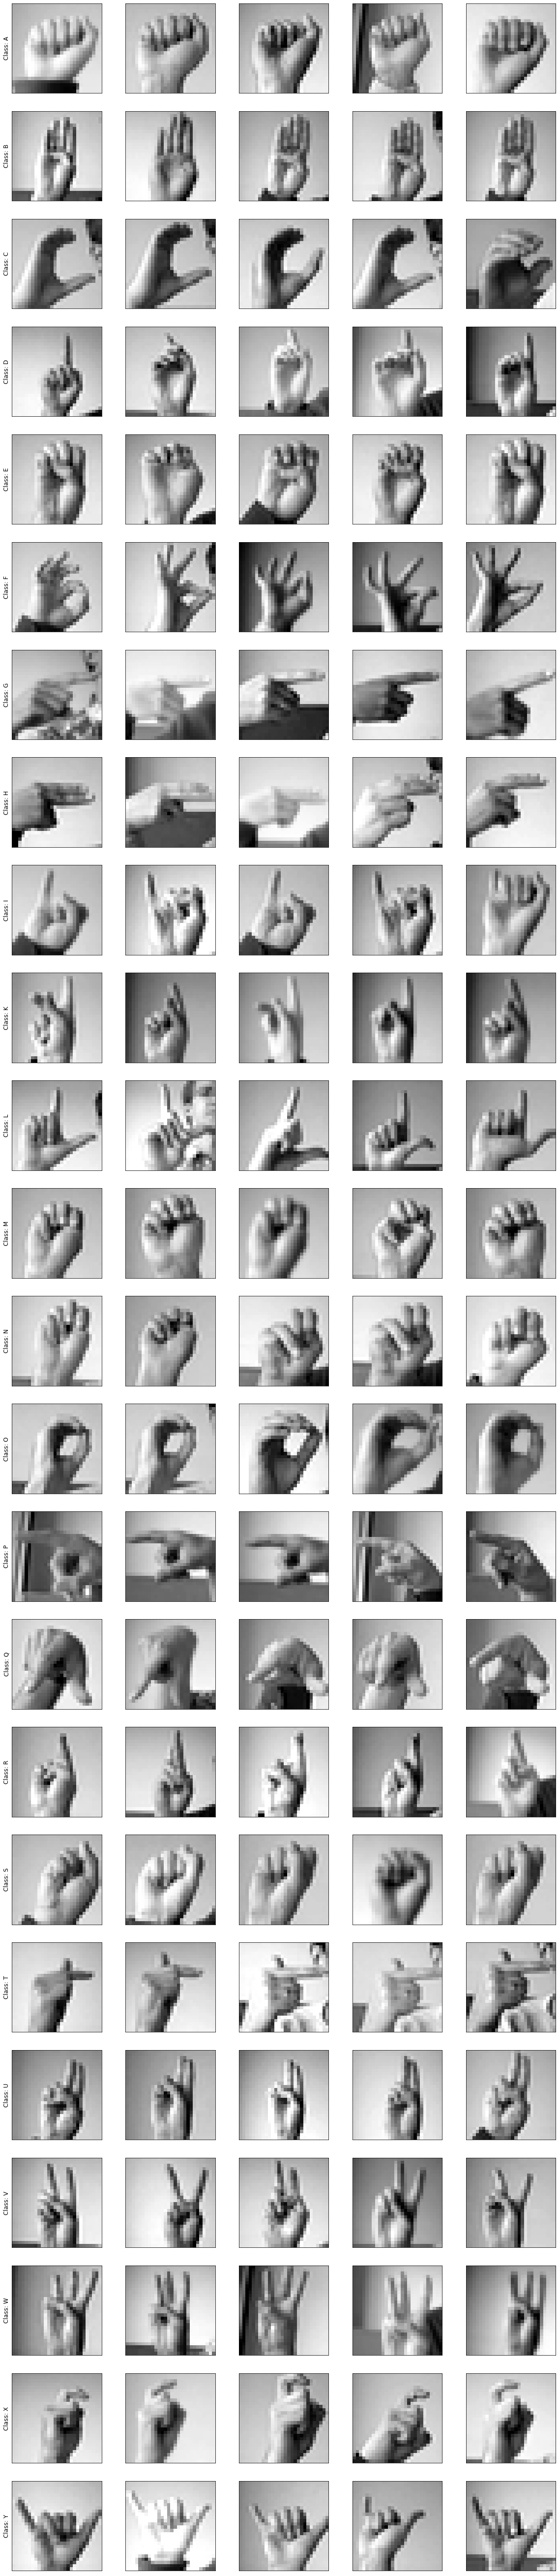

In [15]:
images = asl_trn_df.drop('label', axis=1).values
labels = asl_trn_df['label'].values

display_classes(images, labels, class_names, shape=(28,28), n_samples=5)

In [16]:
garbage_collect(['images', 'labels', 'first_sample_df'])

# Data Preparation Pipeline

Now it's time to recreate our data preparation pipelines we used in prior weeks. In this lab we will, once again, apply all our data cleaning and transformation operations AFTER splitting the data since the data is technically partly split already. 


## Feature-label splitting

Below, are the splitting functions we'll be using once again to split our data. 

In [17]:
def feature_label_split(df: pd.DataFrame, 
                        label_name: str) -> Tuple[pd.DataFrame]:
    """ Split dataframe into features and labels
    
        Args:
            df: DataFrame containing both features and labels
            
            label_name: Name of the column which contains the labels
    """
    
    X = df.drop(label_name, axis=1)
    y = df[[label_name]].copy()
    
    return X, y

Notice, we need to split both the training and testing data since the features and labels are given in the same CSV. You can see this by referring to the `TEST_feature_label_split_train()` and `TEST_feature_label_split_test()` functions.

In [18]:
def TEST_feature_label_split_train():
    X, y = feature_label_split(asl_trn_df, label_name='label')
    display(X)
    display(y)
    
TEST_feature_label_split_train()
garbage_collect(['TEST_feature_label_split_train'])

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,107,118,127,134,139,143,146,150,153,156,...,207,207,207,207,206,206,206,204,203,202
1,155,157,156,156,156,157,156,158,158,157,...,69,149,128,87,94,163,175,103,135,149
2,187,188,188,187,187,186,187,188,187,186,...,202,201,200,199,198,199,198,195,194,195
3,211,211,212,212,211,210,211,210,210,211,...,235,234,233,231,230,226,225,222,229,163
4,164,167,170,172,176,179,180,184,185,186,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,189,189,190,190,192,193,193,193,193,194,...,132,165,99,77,52,200,234,200,222,225
27451,151,154,157,158,160,161,163,164,166,167,...,198,198,198,198,198,196,195,195,195,194
27452,174,174,174,174,174,175,175,174,173,173,...,121,196,209,208,206,204,203,202,200,200
27453,177,181,184,185,187,189,190,191,191,190,...,119,56,27,58,102,79,47,64,87,93


,label
0,3
1,6
2,2
3,2
4,13
...,...
27450,13
27451,23
27452,18
27453,17


In [19]:
def TEST_feature_label_split_test():
    X, y = feature_label_split(asl_tst_df, label_name='label')
    display(X)
    display(y)
    
TEST_feature_label_split_test()
garbage_collect(['TEST_feature_label_split_test'])

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,149,149,150,150,150,151,151,150,151,152,...,138,148,127,89,82,96,106,112,120,107
1,126,128,131,132,133,134,135,135,136,138,...,47,104,194,183,186,184,184,184,182,180
2,85,88,92,96,105,123,135,143,147,152,...,68,166,242,227,230,227,226,225,224,222
3,203,205,207,206,207,209,210,209,210,209,...,154,248,247,248,253,236,230,240,253,255
4,188,191,193,195,199,201,202,203,203,203,...,26,40,64,48,29,46,49,46,46,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7167,135,119,108,102,105,99,61,103,121,133,...,108,112,116,114,118,180,184,176,167,163
7168,157,159,161,164,166,166,171,174,175,176,...,213,213,213,214,213,211,210,210,209,208
7169,190,191,190,191,190,190,192,192,191,192,...,216,215,213,214,214,213,210,211,209,208
7170,201,205,208,209,214,216,218,223,226,229,...,112,169,255,255,237,113,91,67,70,63


,label
0,6
1,5
2,10
3,0
4,3
...,...
7167,1
7168,12
7169,2
7170,4


## Binarize classes

Next, we need to redefine the `binarize_classes()` function we used in prior classification labs. Recall, the logistic regression using the sigmoid function only works for binary classification problems! 

Take note, there are have been some slight changes made to the `binarize_classes()` function, however it functions the same. 

In [20]:
def binarize_classes(
    X_df: pd.DataFrame,
    y_df: pd.DataFrame, 
    pos_class: List, 
    neg_class: List,
    neg_label = 0,
    pos_label = 1,
) -> pd.DataFrame:
    """ Converts a multi-class classification problem into a binary classification problem.
        Args:
            X_df: Pandas DataFrame containing input features.
            
            y_df: Pandas DataFrame continaing target/labels.
            
            pos_class: A list of unique labels/targets found in y_df that will be used
                to create the positive class.
                
            neg_class: A list of unique labels/targets found in y_df that will be used
                to create the negative class.
                
            neg_label: Label used for the negative class.
            
            pos_label: Label used for the positive class.
    """
    
    
    if not isinstance(X_df, pd.DataFrame):
        err = f"X_df is of type {type(X_df)}: expected pd.DataFrame"
        raise TypeError(err)
    
    if not isinstance(y_df, pd.DataFrame):
        err = f"y_df is of type {type(y_df)}: expected pd.DataFrame"
        raise TypeError(err)
    
    pos_locs = y_df.isin(pos_class).values
    pos_X = X_df[pos_locs].copy()
    pos_X.reset_index(inplace=True, drop=True)
    pos_y = y_df[pos_locs].copy()
    pos_y.reset_index(inplace=True, drop=True)
    pos_y.loc[:] = pos_label
    
    neg_locs = y_df.isin(neg_class).values
    neg_X = X_df[neg_locs].copy()
    neg_X.reset_index(inplace=True, drop=True)
    neg_y = y_df[neg_locs].copy()
    neg_y.reset_index(inplace=True, drop=True)
    neg_y.loc[:] = neg_label

    new_X_df = pd.concat([pos_X, neg_X])
    new_y_df = pd.concat([pos_y, neg_y])
    
    return new_X_df, new_y_df

Below the `TEST_binarize_classes_train()` and `TEST_binarize_classes_test()` functions show how to run the `binarize_classes()` function for both the training and testing data.

In [21]:
def TEST_binarize_classes_train():
    # Split data into features and labels
    X_trn, y_trn = feature_label_split(asl_trn_df, label_name='label')

    X_trn, y_trn = binarize_classes(X_trn, y_trn, pos_class=[0], neg_class=[1])

    print(f"X_trn shape: {X_trn.shape}")
    print(f"y_trn shape: {y_trn.shape}")
    print(f"y_trn shape: {y_trn.shape}")

    trn_labels, trn_class_counts = np.unique(y_trn['label'], return_counts=True)
    print(f"\nUnique class labels:\n\t{trn_labels}")
    print(f"Unique class label counts:\n\t{trn_class_counts}")
    
TEST_binarize_classes_train()
garbage_collect(['TEST_binarize_classes_train'])

X_trn shape: (2136, 784)
y_trn shape: (2136, 1)
y_trn shape: (2136, 1)

Unique class labels:
	[0 1]
Unique class label counts:
	[1010 1126]


In [22]:
def TEST_binarize_classes_test():
    # Split data into features and labels
    X_tst, y_tst = feature_label_split(asl_tst_df, label_name='label')

    X_tst, y_tst = binarize_classes(X_tst, y_tst, pos_class=[0], neg_class=[1])

    print(f"X_tst shape: {X_tst.shape}")
    print(f"y_tst shape: {y_tst.shape}")
    print(f"y_tst shape: {y_tst.shape}")

    tst_labels, tst_class_counts = np.unique(y_tst['label'], return_counts=True)
    print(f"\nUnique class labels:\n\t{tst_labels}")
    print(f"Unique class label counts:\n\t{tst_class_counts}")
    
    
TEST_binarize_classes_test()
garbage_collect(['TEST_binarize_classes_test'])

X_tst shape: (763, 784)
y_tst shape: (763, 1)
y_tst shape: (763, 1)

Unique class labels:
	[0 1]
Unique class label counts:
	[432 331]


## Train-validation splitting

As we already have a test set. We only need to split the training set into a validation set. Thus, we define the `train_valid_split()` function to split data into train and validation sets.

In [23]:
from sklearn.model_selection import train_test_split

def train_valid_split(X, y, test_size=.2, seed=42):
    X_trn, X_vld, y_trn, y_vld = train_test_split(X, y, test_size=test_size, random_state=seed)

    return X_trn, y_trn, X_vld, y_vld

The below `TEST_train_valid_split()` function provides example code for how to call both functions `feature_label_split()` and `train_valid_split()`.

In [24]:
def TEST_train_valid_split():
    # Split into features and labels
    X_trn, y_trn = feature_label_split(asl_trn_df, label_name='label')
    # Split into train, validation, and test sets
    X_trn, y_trn, X_vld, y_vld = train_valid_split(X_trn, y_trn)

    print(f"X_trn shape: {X_trn.shape}")
    print(f"y_trn shape: {y_trn.shape}")
    print(f"X_vld shape: {X_vld.shape}")
    print(f"y_vld shape: {y_vld.shape}")
    
TEST_train_valid_split()
garbage_collect(['TEST_train_valid_split'])

X_trn shape: (21964, 784)
y_trn shape: (21964, 1)
X_vld shape: (5491, 784)
y_vld shape: (5491, 1)


## Transforming and cleaning data

This module's data cleaning will be pretty easy even though we need to perform some extra cleaning steps. 

In this lab, we'll need to first clean our labels/targets by converting them to a one-hot encoding using our `OneHotEncoding` class from previous labs. In regards to feature cleaning, all we need to do is standardize the data and add the bias term!

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

### Target cleaning
Below is the `OneHotEncoding` class using in prior labs. Recall, we'll use this class when using the softmax activation function only!

In [26]:
from sklearn.preprocessing import OneHotEncoder


class OneHotEncoding(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names='auto'):
        self.feature_names = feature_names
        self.encoder = OneHotEncoder(categories=feature_names, sparse=False)

    def fit(self, X: pd.DataFrame):
        
        self.encoder.fit(X)
        
        # Store names of features
        self.feature_names = self.encoder.get_feature_names_out()
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        
        one_hot =  self.encoder.transform(X)

        return pd.DataFrame(one_hot, columns=self.get_feature_names_out())
    
    def get_feature_names_out(self, name=None)-> pd.Series:
        return self.feature_names


#### TODO 4
Complete the TODO by coding the `target_pipeline()` function.

1. Complete the `target_pipeline()` function as follows: 
    1. Define an instance of Sklearn's `Pipeline` class which applies the `OneHotEncoding` class. 

    2. Fit and transform the training labels `y_trn`.

    3. Transform the validation labels `y_vld`. 

    4. Transform the test labels `y_tst`.

    5.  Return the cleaned output for training, validation, and testing labels. The order of returned values should be training, validation, and then testing.


In [27]:
# TODO 4.1
def target_pipeline(
    y_trn: pd.DataFrame,
    y_vld: pd.DataFrame,
    y_tst: pd.DataFrame
) ->  List[pd.DataFrame]:
    """ Creates Pipeline to apply data cleaning and transformations 
        to the targets/labels.
        
        Args:
            y_trn: train labels
            
            y_vld: validation labels
            
            y_tst: test labels
    """
    target_pipe = Pipeline([
        ('hot', OneHotEncoding())
    ])
    
    y_trn_clean = target_pipe.fit_transform(y_trn)
    y_vld_clean = target_pipe.transform(y_vld)
    y_tst_clean = target_pipe.transform(y_tst)
    
    return y_trn_clean, y_vld_clean, y_tst_clean


Run the below `TEST_target_pipeline()` function to test your implementation of the `target_pipeline()` function.

In [28]:
def TEST_target_pipeline():
    # Split data into features and labels
    X_trn, y_trn = feature_label_split(asl_trn_df, label_name='label')
    X_tst, y_tst = feature_label_split(asl_tst_df, label_name='label')
    # Split into train, validation, and test sets
    X_trn, y_trn, X_vld, y_vld = train_valid_split(X_trn, y_trn)
    # Clean targets
    y_trn, y_vld, y_tst = target_pipeline(y_trn, y_vld, y_tst)

    print(f"y_trn shape: {y_trn.shape}")
    print(f"y_vld shape: {y_vld.shape}")
    print(f"y_tst shape: {y_tst.shape}")

    display(y_trn)

    todo_check([
        (y_trn.shape == (21964, 24), "y_trn does not have the shape (21964, 24)"),
        (y_vld.shape == (5491, 24),"y_vld does not have the shape (5491, 24)"),
        (y_tst.shape == (7172, 24),"y_tst does not have the shape (7172, 24)"),
        (np.all(class_labels[[np.argmax(y_trn.iloc[0]), np.argmax(y_trn.iloc[-2])]] == [10, 7]), "y_trn has incorrect values"),
        (np.all(class_labels[[np.argmax(y_vld.iloc[0]), np.argmax(y_vld.iloc[-2])]] == [24,20]),"y_vld has incorrect values"),
        (np.all(class_labels[[np.argmax(y_tst.iloc[0]), np.argmax(y_tst.iloc[-2])]] == [6,4]), "y_tst has incorrect values"),
    ])
    
TEST_target_pipeline()
garbage_collect(['TEST_target_pipeline'])

y_trn shape: (21964, 24)
y_vld shape: (5491, 24)
y_tst shape: (7172, 24)


,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8,label_10,...,label_15,label_16,label_17,label_18,label_19,label_20,label_21,label_22,label_23,label_24
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21960,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Your code PASSED the code check!


### Feature cleaning

The only feature cleaning classes we'll need is our `Standardization` and `AddBias` classes which we redefine for you below.

In [29]:
 class AddBias(BaseEstimator, TransformerMixin):
    def fit(self,
            X: pd.DataFrame, 
            y: pd.DataFrame = None) -> pd.DataFrame:
        return self
    
    def transform(self,
                  X: pd.DataFrame, 
                  y: pd.DataFrame = None) -> pd.DataFrame:
        X = X.copy()
        X.insert(0, 'bias', 1)
        return X
    
class Standardization(BaseEstimator, TransformerMixin):
    def __init__(self, epsilon=1e-6):
        self.epsilon = epsilon
    
    def fit(self, X: Union[np.ndarray, pd.DataFrame], y: pd.DataFrame = None):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        return self
    
    def transform(self, X):
        X = (X  - self.mean) / (self.std + self.epsilon)
        return X.astype(np.float32) 

#### TODO 5
Complete the TODO by coding the `feature_pipeline()` function.

1. Define the `feature_pipeline()` function as follows:
   1. Define an instance of Sklearn's `Pipeline` class which applies the `Standardization` and `AddBias` classes. 

    2. Fit and transform the training data `X_trn`.

    3. Transform the validation data `X_vld`. 

    4. Transform the test data `X_tst`.

    5.  Return the cleaned output for training, validation, and testing data. The order of returned values should be training, validation, and then testing.


In [30]:
# TODO 5.1
def feature_pipeline(
    X_trn: pd.DataFrame,
    X_vld: pd.DataFrame,
    X_tst: pd.DataFrame, 
) -> List[pd.DataFrame]:
    """ Creates Pipeline to apply data cleaning and transformations 
        to the input features of our data.
        
        Args:
            X_trn: train features
            
            X_vld: validation features
            
            X_tst: test features
    """
    feature_pipe = Pipeline([
        ('scaler', Standardization()),
        ('bias', AddBias())
    ])
    
    X_trn_clean = feature_pipe.fit_transform(X_trn)
    X_vld_clean = feature_pipe.transform(X_vld)
    X_tst_clean = feature_pipe.transform(X_tst)
    
    return X_trn_clean, X_vld_clean, X_tst_clean

Run the below `TEST_feature_pipeline()` function to check you implementation of the `feature_pipeline()` class.

In [31]:
def TEST_feature_pipeline():
    # Split data into features and labels
    X_trn, y_trn = feature_label_split(asl_trn_df, label_name='label')
    X_tst, y_tst = feature_label_split(asl_tst_df, label_name='label')
    # Split into train, validation, and test sets
    X_trn, y_trn, X_vld, y_vld = train_valid_split(X_trn, y_trn)
    # Apply feature cleaning AFTER splitting
    X_trn, X_vld, X_tst = feature_pipeline(X_trn, X_vld, X_tst)

    print(f"X_trn shape: {X_trn.shape}")
    print(f"X_tst shape: {X_tst.shape}")
    display(X_trn)

    todo_check([
        ('bias' in X_trn.columns,"X_trn did not have a bias column"),
        ('bias' in X_vld.columns,"X_vld did not have a bias column"),
        ('bias' in X_tst.columns, "X_tst did not have a bias column"),
        (np.isclose(X_trn.iloc[0].mean(), -1.054699, rtol=.01), "X_trn has incorrect values"),
        (np.isclose(X_vld.iloc[0].mean(), 0.012305, rtol=.01),"X_vld has incorrect values"),
        (np.isclose(X_tst.iloc[0].mean(), -0.6328418, rtol=.01),"X_tst has incorrect values"),
    ])
    
TEST_feature_pipeline()
garbage_collect(['TEST_feature_pipeline'])

X_trn shape: (21964, 785)
X_tst shape: (7172, 785)


,bias,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
22706,1,-1.176200,-2.098060,-0.600129,-2.854492,-3.760392,-2.532840,-2.758344,-2.866820,-2.909831,...,0.746585,0.491823,-0.305828,-0.978212,-1.352838,-1.213103,-1.089376,-1.139868,-1.099969,-1.066928
1231,1,1.679378,1.688488,1.682091,1.801566,1.339504,0.483779,0.440272,0.848864,-1.776970,...,-0.131832,-0.226706,-0.336871,-0.428980,-0.442787,-0.614019,0.061683,-0.602116,-2.167454,-0.306548
531,1,-0.038809,-0.091942,-0.138556,-0.175308,-0.171576,-0.235782,-0.273705,-0.340155,-0.399166,...,-0.994564,-0.624191,0.454717,0.434099,0.137762,-0.046466,-0.505963,-0.443953,-0.942986,-1.361770
21099,1,-1.974794,-1.897448,-1.754061,-1.501894,-1.493772,-1.398149,-1.416068,-1.410272,-1.409555,...,0.338749,0.293081,0.237418,0.151636,0.122072,0.158483,0.156290,0.204513,0.218689,0.252099
17752,1,-1.514997,-1.521301,-2.420777,-2.048135,-1.493772,-3.363102,-4.100621,-2.955997,-2.909831,...,-0.853390,-1.174554,-1.578577,-1.009597,0.326049,0.205779,0.266666,0.315227,0.359974,0.407279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,1,-0.643804,-0.718854,-0.779629,-0.825595,-0.819182,-0.650913,-0.473619,-0.221253,-0.092987,...,0.197574,-0.058540,0.796186,0.983330,0.749693,0.631444,0.392809,-0.095996,-0.487735,-0.446209
5390,1,0.808185,0.785735,0.758946,0.735095,0.745866,0.732858,0.640185,0.640785,0.641842,...,-0.790645,-1.679053,-1.764833,-1.527444,-1.494053,-1.354991,-1.026304,-1.029154,-1.366840,-1.672129
860,1,1.146982,1.136806,1.117947,1.125267,1.150619,1.147989,1.182808,1.205569,1.223581,...,-0.210262,-0.318434,-0.414477,-0.491750,-0.552621,-0.598254,-0.616338,-0.649564,-0.644718,-0.663461
15795,1,1.316381,1.312341,1.220519,1.151279,1.150619,1.120313,1.125690,1.116393,1.101110,...,-0.461239,-1.220417,-1.671705,0.418406,0.122072,-0.882030,-0.726713,-0.554667,-1.413935,-1.547985


Your code PASSED the code check!



## Putting it all together

In order to make our lives easier we create a function called `data_prep()` which will run the binarization of our classes, splitting, and the target/feature data cleaning and transformations for us. Thus, whenever we go to implement a new algorithm we can call `data_prep()` to give us our data and override any other variables with the same names!

**Take time to also read the DocStrings or in-line documentation, given at the start of the function, which describes what each argument does. You need to understand what each argument does before moving forward!**

Note: Any arguments in a function given after the `*` in the function definition below MUST be passed using the keyword. See this [post](https://stackoverflow.com/questions/14301967/bare-asterisk-in-function-arguments) for more information.

In [32]:
def data_prep(
    trn_df: pd.DataFrame,
    tst_df: pd.DataFrame,
    label_name: str,
    *,
    pos_class: List[int] = None,
    neg_class: List[int] = None,
    use_target_pipeline: bool = False,
    seed: int = 42,
    return_array: bool = False,
) -> Tuple[pd.DataFrame]:
    """ Binarizes data, splits data and runs data cleaning 
        and transformations.
    
        Args:
            trn_df: A Pandas DataFrame containing the training dataset 
                for the current lab.
                
            tst_df: A Pandas DataFrame containing the testing dataset 
                for the current lab.
                
            label_name: Name of the column in the DataFrame which
                will be used as the label/target. This will be passed
                to the feature_label_split() function.
            
            pos_class: List of labels to be converted into
                the postive class. This will be passed to the
                binarize_classes() function.
                
            neg_class: List of labels to be converted into the 
                negative class. This will be passed to the
                binarize_classes() function.
            
            use_target_pipeline: If True then the target_pipeline()
                function will be called and labels/targets will be
                cleaned/transformed.
            
            seed: The seed used when splitting data into train, 
                validation, and test. This will be passed to the
                train_valid_test_split() function.
            
            return_array: A boolean which when True will return all data as NumPy
                arrays instead of Pandas DataFrames.
    """
    # Apply feature and label splitting
    X_trn, y_trn = feature_label_split(trn_df, label_name=label_name)
    X_tst, y_tst = feature_label_split(tst_df, label_name=label_name)
    
    # Turn problem into a binary classification problem
    # if pos_class and neg_class are specified
    if pos_class and neg_class:
        X_trn, y_trn = binarize_classes(X_trn, y_trn, pos_class, neg_class)
        X_tst, y_tst = binarize_classes(X_tst, y_tst, pos_class, neg_class)
    
    # Split into train and validation sets
    X_trn, y_trn, X_vld, y_vld = train_valid_split(X_trn, y_trn)
    
    # Target cleaning
    if use_target_pipeline:
        y_trn, y_vld, y_tst = target_pipeline(y_trn, y_vld, y_tst)
    
    # Feature cleaning
    X_trn, X_vld, X_tst = feature_pipeline(X_trn, X_vld, X_tst)

    # Resets the Pandas index for the Dataframe and series
    # This will prevent any headaches when combining or indexing
    # our train, validation, and test data in the future.
    X_trn.reset_index(inplace=True, drop=True)
    y_trn.reset_index(inplace=True, drop=True)
    X_vld.reset_index(inplace=True, drop=True)
    y_vld.reset_index(inplace=True, drop=True)
    X_tst.reset_index(inplace=True, drop=True)
    y_tst.reset_index(inplace=True, drop=True)
        
    # Return data as arrays instead of DataFrames
    if return_array:
        X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = (X_trn.values, 
                                                    y_trn.values, 
                                                    X_vld.values, 
                                                    y_vld.values, 
                                                    X_tst.values, 
                                                    y_tst.values)                  
    
    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

#### TODO 6
1. Call the `data_prep()` so that it will return binary classification data as NumPy arrays by passing the arguments which correspond to the following:
    1. Pass all required arguments for `trn_df`, `tst_df`, and `label_name`.
    1. Set the letter A to be the positive class. 
        1. Hint: Remember to use the class label for A!
    1. Set the letter B to be the negative class. 
        1. Hint: Remember to use the class label for B!
    1. Return all data as NumPy arrays.


2. Call the `data_prep()` so that it will return multi-class classification data as Pandas DataFrames by passing the arguments which correspond to the following:
    1. Pass all required arguments for `trn_df`, `tst_df`, and `label_name`.
    1. Apply the target `target_pipeline()` to labels/targets so that they are one-hot encoded.

In [33]:
def TEST_data_prep1():
    # TODO 6.1
    data = data_prep(asl_trn_df, asl_tst_df, label_name = 'label', pos_class = [0], neg_class = [1], return_array = True)
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = data

    print(f"X_trn type: {type(X_trn)}")
    print(f"X_trn shape: {X_trn.shape}")
    print(f"y_trn shape: {y_trn.shape}")
    print(f"X_vld shape: {X_vld.shape}")
    print(f"y_vld shape: {y_vld.shape}")
    print(f"X_tst shape: {X_tst.shape}")
    print(f"y_tst shape: {y_tst.shape}")

    todo_check([
        (type(X_trn) is np.ndarray, "X_trn is not a NumPy array"),
        (y_trn.shape == (1708, 1), "y_trn does not have the shape (1708, 1)"),
        (y_vld.shape == (428, 1), "y_vld does not have the shape (428, 1)"),
        (y_tst.shape == (763, 1), "y_tst does not have the shape (763, 1)"),
        (np.all(np.unique(y_trn).flatten() == [0, 1]), "y_trn labels are not binary (0 or 1)"),
    ])
    
TEST_data_prep1()
garbage_collect(['TEST_data_prep1'])

X_trn type: <class 'numpy.ndarray'>
X_trn shape: (1708, 785)
y_trn shape: (1708, 1)
X_vld shape: (428, 785)
y_vld shape: (428, 1)
X_tst shape: (763, 785)
y_tst shape: (763, 1)
Your code PASSED the code check!


In [34]:
def TEST_data_prep2(): 
    # TODO 6.2
    data = data_prep(asl_trn_df, asl_tst_df, label_name = 'label', use_target_pipeline = True)
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = data

    print(f"X_trn type: {type(X_trn)}")
    print(f"X_trn shape: {X_trn.shape}")
    print(f"y_trn shape: {y_trn.shape}")
    print(f"X_vld shape: {X_vld.shape}")
    print(f"y_vld shape: {y_vld.shape}")
    print(f"X_tst shape: {X_tst.shape}")
    print(f"y_tst shape: {y_tst.shape}")

    todo_check([
        (type(X_trn) is pd.DataFrame,"X_trn is not a Pandas DataFrame"),
        (y_trn.shape == (21964, 24), "y_trn does not have the shape 21964, 24)"),
        (y_vld.shape == (5491, 24), "y_vld does not have the shape (5491, 24)"),
        (y_tst.shape == (7172, 24), "y_tst does not have the shape (7172, 24)"),
    ])
    
TEST_data_prep2()
garbage_collect(['TEST_data_prep2'])

X_trn type: <class 'pandas.core.frame.DataFrame'>
X_trn shape: (21964, 785)
y_trn shape: (21964, 24)
X_vld shape: (5491, 785)
y_vld shape: (5491, 24)
X_tst shape: (7172, 785)
y_tst shape: (7172, 24)
Your code PASSED the code check!


# Defining Classification Metrics and Plots

Before we get to our algorithms, let's first define the metrics and plots we'll be using to assess how good predictions are. 

### Accuracy
Below we redefine the `accuracy()` function which you defined in last module's lab.

In [35]:
def accuracy(y, y_hat):
    # Convert y from one-hot encoding back to normal
    if len(y.shape) > 1 and y.shape[-1] > 1:
        y = np.argmax(y, axis=1).reshape(-1,1)

    total_correct = np.sum(y_hat == y)
    total_samples = len(y)
    print(f"Accuracy ratio: {total_correct}/{total_samples}")
    return total_correct / total_samples

### Confusion Matrix

Keep in mind, we will be looking at multi-class classification which means the confusion matrix will be a 3x3 since we have 3 classes. Recall the confusion for **binary classification** looked like the below image.

<img src="http://www.andrewgurung.com/wp-content/uploads/2018/12/confusion_matrix.png" width=500 height=500>


The below image is what a **multi-class classification confusion matrix** looks like. Further, the below image shows how to determine the false positives, true positives, false negatives, and true negatives for each class. More on this later in the lab.


<img src="https://i.stack.imgur.com/AuTKP.png" width=300 height=300>


In [36]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y, y_hat, class_names=None, figsize=(6, 4)):
    # Convert y from one-hot encoding back to normal
    if len(y.shape) > 1 and y.shape[-1] > 1:
        y = np.argmax(y, axis=1).reshape(-1,1)

    cfm = confusion_matrix(y_pred=y_hat, y_true=y)

    labels = np.sort(np.unique(y))
    if class_names is not None:
        classes = []
        for l in labels:
            class_name = class_names.get(l, l)
            classes.append(class_name)
        labels = classes

    columns, index = labels, labels
    cfm_df = pd.DataFrame(cfm, index=index, columns=columns)
    fig, ax = plt.subplots(figsize=figsize)  
    sns.heatmap(cfm_df, annot=True, fmt='d', cmap='Blues', ax=ax)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Acutal', fontsize=14)
    return cfm

### Other scores

Below we define functions for the positive predictive value (PPV) or precision, True positive rate (TPR) or recall, and true negative rate (TNR) or specificity.

$$
\text{PPV} = \frac{\text{TP}}{\text{TP} + \text{FP}}
$$

$$
\text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$

$$
\text{TNR} = \frac{\text{TN}}{\text{TN} + \text{FP}}
$$

Lastly, we define `compute_scores()` which will automatically compute the PPV, TPR, and TNR scores for each class using the multi-class confusion matrix.

In [37]:
def ppv(tp, fp):
    return tp / (tp + fp)

def tpr(tp, fn):
    return tp / (tp + fn)

def tnr(tn, fp):
    return tn / (tn + fp)

def compute_scores(y, y_hat, class_names=None):
    def print_scores(tn, fn, fp, tp):

        print(f"\tPPV ratio tp/(tp+fp): {tp}/{tp+fp}")
        print(f"\tPPV (precision): {ppv(tp=tp, fp=fp) }\n")

        print(f"\tTPR ratio tp/(tp+fn): {tp}/{tp+fn}")
        print(f"\tTPR (recall/sensitivity): {tpr(tp=tp, fn=fn)}\n")

        print(f"\tTNR ratio tn/(tn+fp): {tn}/{tn+fp}")
        print(f"\tTNR (specificity): {tnr(tn=tn, fp=fp)}")
    
    if class_names is None:
        class_names = {}
    
    # Convert y from one-hot encoding back to normal
    if len(y.shape) > 1 and y.shape[-1] > 1:
        y = np.argmax(y, axis=1).reshape(-1,1)
    
    cm = confusion_matrix(y_true=y, y_pred=y_hat)
    
    # Computing multi-class classification tp, fn, tp, tn
    fp = cm.sum(axis=0) - np.diag(cm)  
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)
    
    ppv_ = ppv(tp=tp, fp=fp) 
    tpr_ = tpr(tp=tp, fn=fn)
    tnr_ = tnr(tn=tn, fp=fp)
    
    class_labels = np.unique(y)
    
    if len(class_labels) == 2:
        class_name = class_names.get(class_labels[-1], class_labels[-1])
        print(f"Scores for binary problem: positive label is {class_name}")
        print_scores(tn[-1], fn[-1], fp[-1], tp[-1])
    else:
        for i, label in enumerate(class_labels):
            class_name = class_names.get(label, label)
            print(f"Scores for class {class_name}")
            print_scores(tn[i], fn[i], fp[i], tp[i])

    return ppv_, tpr_, tnr_

# Binary Logistic Regression

We'll start off by first coding and applying logistic regression using the sigmoid function. As such, we'll to convert our multi-class classification problem into a binary classification problem which we'll do later on in this section.

## Defining Logistic Regression with Sigmoid

Before outright defining a logistic regression class let's go through the main components of the algorithm first. Recall the image which summarizes how the logistic regression works given below.

<img src="https://sebastianraschka.com/images/faq/logisticregr-neuralnet/schematic.png" width=500 height=500>


There are two main parts we'll need to review and define before creating our logistic regression class:

1. First, we'll need to define the activation function which will be the *sigmoid* activation function. 
2. Second, we'll need a loss (i.e., cost) function to assess how well logistic regression is doing at classifying the data. We can do this by reformulating the *negative log loss* (NLL) loss function as a binary loss function that can be derived and used for gradient descent optimization. 

### Sigmoid

Recall, the sigmoid activation function will squash the continuous output $z$ to values that range from 0 to 1. Since the values are squashed between 0 and 1, we can use a binary classification setup where the outputs of logistic regression correspond to probability a given data sample belongs to the positive class.

Additionally, recall the sigmoid function equation is defined as given below:

$$
\begin{align}
P(y \mid \xv; \wv) = f(\xv; \wv) &= \frac{1}{1 + e^{-z}} \\
&= \frac{1}{1 + e^{-\wv^\top \xv}} \\
&= \frac{e^{\wv^\top \xv}}{1 + e^{\wv^\top \xv}} 
\end{align}
$$

where the equation $\frac{e^z}{1 + e^{z}}$ is an alternative formulation of the sigmoid function which is useful when programming as it can prevent overflow errors when $z$ is a very small negative value. Meanwhile, the original sigmoid formulation $\frac{1}{1 + e^{-z}}$ is useful when you want prevent overflow when $z$ is a very large positive value.

Visually, the sigmoid function looks as the image given below.

<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fthemaverickmeerkat.com%2Fimg%2Fsoftmax%2Fsigmoid_plot.jpg&f=1&nofb=1" width=300 height=300>

#### TODO 7
Complete this TODO by implementing the `sigmoid()` function such that it returns the output of the sigmoid equation given above. 

1. Finish the `sigmoid()` function by converting the sigmoid equation into code. Return the output of the sigmoid equation.
    1. Hint: Try programming the $\frac{e^{z}}{1 + e^{z}}$ version of the sigmoid function as this will prevent any overflow warnings later on for this particular dataset. However, either version of the equation will technically work.

In [38]:
# TODO 7.1
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

Run the below code to visualize and test your implementation of the `sigmoid()` function. 

Your code PASSED the code check!


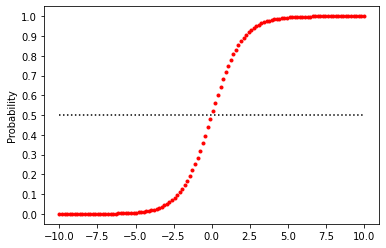

In [39]:
x_values = np.linspace(-10, 10, 120)
y_values = sigmoid(x_values)

todo_check([
    (np.all(np.isclose(y_values[:3], np.array([4.53978687e-05, 5.37059651e-05, 6.35343990e-05]),rtol=.01)), "The returned sigmoid values were incorrect")
])

plt.plot(x_values, y_values, '.r')
plt.hlines(y=.5, xmin=x_values.min(), xmax=x_values.max(), 
           colors='black', linestyles='dotted')
plt.yticks(np.arange(0, 1+.1, .1))
plt.ylabel("Probability")

plt.show()

Remember, if we pass a vector $\zv$ to the `sigmoid()` function we get a vector output. Think of this as passing multiple data sample predictions to the function at once. We can see this idea in action in the below code cell.

In [40]:
y_values = sigmoid(x_values)
y_values.shape

(120,)

In [41]:
garbage_collect(['x_values', 'y_values'])

### Binary Negative Log Loss
Now, it's time to define the NLL. Recall from the notes that we formulate the NLL loss function as an indicator function where $y \in [0, 1]$ as follows:

$$
NLL(\wv) =\begin{cases}
    & -\log(f(\xv;\wv)) \, \text{if} \, y = 1\\
    & -\log(1- f(\xv;\wv)) \ \text{if} \ y = 0\\
\end{cases}
$$

where $P(y \mid \xv; \wv) = f(\xv; \wv)$. Sadly, formulating NLL loss function as an indicator function isn't very useful for optimization with gradient descent as the derivative can NOT be computed from the indicator function. Instead we can actually turn said indicator function into an actual equation.

We can reformulate the NLL loss function into an actual equation by utilizing the [Bernoulli probability mass function equation](https://en.wikipedia.org/wiki/Bernoulli_distribution). Without applying the $\log$, we get the following equation:


$$
NLL(\wv) = - \prod_{i=1}^{m} f(\xv_i;\wv)^{y_i} (1 - f(\xv_i;\wv))^{1 - y_i}     
$$

Applying the $\log$, we then get the following NLL loss function for binary classification:
$$
NLL(\wv) = - \sum_{i=1}^{m} {y_i}\log[f(\xv_i;\wv)] + ({1 - y_i})\log[1 - f(\xv_i;\wv)]     
$$


Finally, we can compute the average loss for NLL by simply dividing by $m$ or the number of data samples.

$$
NLL(\wv) = - \frac{1}{m}\sum_{i=1}^{m} {y_i}\log[f(\xv_i;\wv)] + ({1 - y_i})\log[1 - f(\xv_i;\wv)] 
$$

The above equations are what we'll refer to as the binary NLL which is what we want to implement in this section!

#### TODO 8

Before defining a function for binary NLL let's breakdown the equation so we can see and understand how the loss function works. Complete the TODO by implementing parts of the binary NLL equation and then implementing the `binary_nll()` function.

1. Convert the binary log likelihood equation given below into code. Notice that the negative sum is not included on purpose! Use `fake_y` in place of $y$ and `fake_probs` in place of $f(\xv_i;\wv)$. Store the output into losses.

$$
LL(\wv) = {y_i}\log[f(\xv_i;\wv)] + ({1 - y_i})\log[1 - f(\xv_i;\wv)
$$

2. Compute the average NLL loss for all data samples stored in `losses`. Remember to apply the negative after taking the average. Store the output into `avg_loss`.


3. Using the prior TODOs as guidance, implement the `binary_nll()` function by converting the NLL equation, given below, into code. Return the output of the NLL equation.
    1. **Be sure to to add the `epsilon` to the input `probs` inside the $\log$.** If you don't do this NumPy will throw warning as we can not take the $\log$ of zero and you will get `nan` values when training! For those that don't know, it is common to add really small numbers to values that could potentially be zero to prevent these types of errors!

$$
\begin{align}
NLL(\wv) = &- \frac{1}{m}\sum_{i=1}^{m} {y_i}\log[f(\xv_i;\wv)+\epsilon] \\
&+ ({1 - y_i})\log[1 - f(\xv_i;\wv)+\epsilon] 
\end{align}
$$

Below we define some fake labels `fake_y` and fake predicted probabilities `fake_probs`. Remember, each row corresponds to a data sample. This means, each row of `fake_y` is a label and each row of `fake_probs` is the a probability that data sample belongs to the positive class.  

In [42]:
fake_y = np.array([[1], [0], [1]])
fake_probs = np.array([[0.8], [0.4], [.1]])

In [43]:
fake_y

array([[1],
       [0],
       [1]])

In [44]:
fake_probs

array([[0.8],
       [0.4],
       [0.1]])

After implementing this function, assuming it is correct, you'll see that we get the *log likelihood* for each data sample. There are few important things to notice about this output given as follows:

1. First, notice, we haven't applied the negative (which negates the negatives of the log likelihood) so it isn't quite the NLL.
1. Second, note, we haven't applied the sum or mean so we can't say the below output is the average NLL loss, rather it is the log loss for EACH data sample.



In [45]:
# TODO 8.1
losses = fake_y*np.log(fake_probs) + (1-fake_y)*np.log(1-fake_probs)

print(f"Log losses:\n{losses}")

todo_check([
    (np.all(np.isclose(losses.flatten(), [-0.22314355, -0.51082562, -2.30258509],rtol=.01)), "losses values are incorrect")
])

Log losses:
[[-0.22314355]
 [-0.51082562]
 [-2.30258509]]
Your code PASSED the code check!


We can easily get the NLL by taking the negative of the log losses  variable `losses`.

In the below output, notice the following:

1. First, notice the first data sample has a low loss because its label is 1 (i.e., positive class) and it predicted that the sample belongs to the positive class with a relatively high probability of 80%. 

1. Next, notice how the second data sample has slightly higher loss because its label is 0 (i.e., negative class) and it predicted that the data sample belongs to the positive class with 40% probability (i.e., 60% that it belongs to the negative class). While this prediction would lead to the correct label being chosen (i.e., the negative label), the loss still punishes the probability such that it will hopefully be higher next time the data sample or a similar data sample is seen.

1. Finally, notice how the third data sample has a really high loss because its label is 1 and it predicted that the data sample belongs to the positive class with only 10% probability. Thus, binary NLL punishes this prediction for being vastly incorrect in an effort to, once again, greatly raise the probability.



In [46]:
neg_losses = -losses
print(f"Negative log losses:\n{neg_losses}")

Negative log losses:
[[0.22314355]
 [0.51082562]
 [2.30258509]]


Once the below code is correctly implemented, you can see we compute the average binary NLL loss over all the fake data samples.

In [47]:
# TODO 8.2
avg_loss = -np.sum(losses) / len(fake_y)
print(f"Average loss: {avg_loss}")

todo_check([
    (np.isclose(avg_loss, 1.0121, rtol=.01), "avg_loss value is incorrect")
])

Average loss: 1.0121847560247488
Your code PASSED the code check!


In [48]:
def binary_nll(y, probs, epsilon=1e-4):
    # TODO 8.3
    pos_class_probs = probs + epsilon
    neg_class_probs = 1 - probs + epsilon

    losses = y * np.log(pos_class_probs) + (1 - y) * np.log(neg_class_probs)
    avg_loss = -np.sum(losses) / len(y)
    
    return avg_loss

Run the below `TEST_binary_nll()` function to test your implementation of the `binary_nll()` function. 

In [49]:
def TEST_binary_nll():
    avg_loss = binary_nll(y=fake_y, probs=fake_probs)
    print(f"Average loss: {avg_loss}")

    todo_check([
        (np.isclose(avg_loss, 1.0121, rtol=.01), "avg_loss value is incorrect")
    ])
    
TEST_binary_nll()
garbage_collect(['TEST_binary_nll'])

Average loss: 1.0117543742578967
Your code PASSED the code check!


In [50]:
garbage_collect(['fake_y', 'fake_probs', 'losses', 'neg_losses', 'avg_loss'])

### Logistic Regression
Now that we have defined both the sigmoid activation function and the binary NLL, we can now implement logistic regression using batch gradient descent.

Recall that batch gradient decent computes the average  gradient using ALL the data at once (depending on the dataset this might be memory intensive and not even possible). Using the NLL loss derivative, the update equation for the weights is given as follows:

$$
\begin{align}
\wv^{\text{new}} &= \wv^{\text{old}} + \alpha \nabla NLL(\wv)\\
&= \wv^{\text{old}} - \alpha \big [ \Xm^\top \big (f(\Xm;\wv) - \yv \big ) \big ]
\end{align}
$$

where in this equation

- $f(\Xm;\wv) = P(y \mid \Xm; \wv) = \hat{\yv}$ is a vector of probabilities where the probability a data sample belongs to the positive class is given for each data sample.
- $\yv$ is a vector of labels for each data sample.
- $\Xm$ is a matrix of features and data samples.

Notice/ this equation eerily similar to the MSE gradient, however it is technically different as $f(\Xm;\wv)$ has the sigmoid function (or another activation function) contained within it.

Additionally, we are going to use [learning curves](https://en.wikipedia.org/wiki/Learning_curve_(machine_learning)) to track the train and validation loss throughout training to help us understand how well our model is learning and if it is overfitting or not learning. Further, we can use learning curves to find an optimal model (more on this in the future). Now, we haven't really discussed learning curves so explanations will be given as we go along.

#### TODO 9
Complete this TODO by implementing the `LogisticRegression` class.

**TODOs for `__init__()` method**

1. Set the class variable `self.g` to store a **reference** to the `sigmoid` activation function. Recall, $g$ is the variable often used for activation function.
2. Set the class variable `self.loss_func` to store a **reference** to the `binary_nll` loss function. 

**TODOs for `init_weights()` method**

3. Initialize the weights so that they have the 2D shape (features, 1). Store the output into `self.w`.

**TODOs for `fit()` method**

4. Make the continuous predictions using the **training** data `X` and weights `self.w`. Store the output into `z`.


5. Pass the continuous **training** output `z` to the sigmoid function stored in `self.g` to get the predicted positive class probabilities. Store the output into `probs`.


6. Compute the average gradient using the gradient, see the below equation. Store the output into `avg_gradient`.

$$
\nabla NLL(\wv) = \frac{1}{m} \Xm^\top \big (f(\Xm;\wv) - \yv \big )
$$

7. Update the weights using the `avg_gradient`. Store the output back into `self.w`.


8. Compute the average **training** loss using the binary NLL function stored in `self.loss_func`. Store the output in `avg_loss`.


9. Append the `avg_loss` to the `self.epoch_losses` list which tracks the average **training** loss per epoch.

10. Make the continuous predictions using the **validation** data `X_vld` and weights `self.w`. Store the output into `z_vld`.


11. Pass the continuous **validation** output `z_vld` to the sigmoid function stored in `self.g` to get the predicted positive class probabilities. Store the output into `vld_probs`.


12. Compute the average **validation** loss using the binary NLL function stored in `self.loss_func`. Store the output in `avg_vld_loss`.


13. Append the `avg_vld_loss` to the `self.vld_epoch_losses` list which tracks the average **validation** loss per epoch

**TODOs for `predict()` method**

14. Make the continuous predictions using the data `X` and weights `self.w`. Store the output into `z`.


15. Pass the continuous output `z` to the sigmoid function stored in `self.g` to get the predicted positive class probabilities. Store the output into `probs`.


16. Select the predicted labels based on the positive probabilities stored in `probs` using a threshold of $0.5$. Store the output into `y_hat` Follow the instructions below for how to do so or see the notes:
    1. First, compute a binary array that returns True if `probs > .5` and False otherwise.
    2. Next, cast the binary array using `np.uint8()` function which converts all values to 0 or 1. This will convert all True values to the positive class (i.e., label 1) and all False values to the negative class (i.e., label 0).

In [259]:
class LogisticRegression():
    def __init__(self, epochs=1, alpha=.01, verbose=True):
        self.epochs = epochs
        self.alpha = alpha
        self.verbose = verbose

        self.w = None
        self.epoch_losses = None
                
        # TODO 9.1
        self.g = sigmoid
        # TODO 9.2
        self.loss_func = binary_nll
        
        
    def init_weights(self, X, y, seed):
        rng = np.random.RandomState(seed)
        # TODO 9.3
        self.w = rng.rand(X.shape[1], 1)
    
    def fit(self, X, y, *, X_vld=None, y_vld=None, seed=0):
        """ Learn weights using batch gradient descent
            while tracking the training and validation
            loss if validation data is provided.
            
            Args:
                X: Training features/data
                
                y: Training labels
                
                X_vld: Validation features/data
                
                y_vld: Validation labels
                
                seed: Seed used for initializing weights
        """
        self.init_weights(X, y, seed)
        self.epoch_losses = []
        self.vld_epoch_losses = []
        for e in range(self.epochs):
            epoch_info = f"Epoch: {e+1}/{self.epochs}"
            
            # TODO 9.4
            z = X @ self.w
 
            # TODO 9.5
            probs = self.g(z)
            # TODO 9.6
            avg_gradient = (X.T @ (probs - y)) / len(y)
            # TODO 9.7
            self.w -= self.alpha * avg_gradient

            # TODO 9.8
            avg_loss = self.loss_func(y, probs)
            # TODO 9.9
            self.epoch_losses.append(avg_loss)
            epoch_info += f"\n\tAvg Training loss: {np.round(avg_loss, 4)}"
            
            if X_vld is not None and y_vld is not None:
                # TODO 9.10
                z_vld = X_vld @ self.w
                # TODO 9.11
                probs_vld = self.g(z_vld)
                # TODO 9.12
                avg_vld_loss = self.loss_func(z_vld, probs_vld)
                # TODO 9.13 
                self.vld_epoch_losses.append(avg_vld_loss)
                epoch_info += f"\n\tAvg Validation loss: {np.round(avg_vld_loss, 4)}"
            if self.verbose: print(epoch_info)

    def predict(self, X):
        # TODO 9.14
        z = X @ self.w
        # TODO 9.15
        probs = self.g(z)
        # TODO 9.16
        y_hat = np.int8(probs > 0.5)
        
        return y_hat.reshape(-1,1)

Run the below `TEST_LogisticRegression()` function to test your implementation of the `LogisticRegression` class.

Epoch: 1/150
	Avg Training loss: 0.2726
	Avg Validation loss: -14.7942
Epoch: 2/150
	Avg Training loss: 0.2585
	Avg Validation loss: -15.6141
Epoch: 3/150
	Avg Training loss: 0.2466
	Avg Validation loss: -16.2961
Epoch: 4/150
	Avg Training loss: 0.2362
	Avg Validation loss: -16.873
Epoch: 5/150
	Avg Training loss: 0.227
	Avg Validation loss: -17.369
Epoch: 6/150
	Avg Training loss: 0.2188
	Avg Validation loss: -17.8018
Epoch: 7/150
	Avg Training loss: 0.2113
	Avg Validation loss: -18.1852
Epoch: 8/150
	Avg Training loss: 0.2045
	Avg Validation loss: -18.5297
Epoch: 9/150
	Avg Training loss: 0.1983
	Avg Validation loss: -18.8436
Epoch: 10/150
	Avg Training loss: 0.1925
	Avg Validation loss: -19.1332
Epoch: 11/150
	Avg Training loss: 0.1872
	Avg Validation loss: -19.4038
Epoch: 12/150
	Avg Training loss: 0.1822
	Avg Validation loss: -19.6595
Epoch: 13/150
	Avg Training loss: 0.1776
	Avg Validation loss: -19.9036
Epoch: 14/150
	Avg Training loss: 0.1733
	Avg Validation loss: -20.1387
Epoc

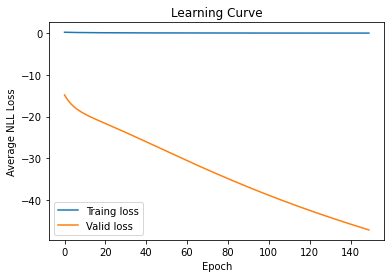

Accuracy ratio: 19/20
Accuracy: 0.95
Weights: [-2.48563101  1.23034373  1.37369204]
Your code PASSED the code check!


In [260]:
def TEST_LogisticRegression():
    
    def nonseparable_linear_data(C1_size=50, C2_size=50):
        mu1 = [-1, -1]
        cov1 = np.eye(2) * 3

        mu2 = [3, 4]
        cov2 = np.eye(2) * 5
        rng = np.random.RandomState(42)
        C1 = rng.multivariate_normal(mu1, cov1, C1_size)
        C2 = rng.multivariate_normal(mu2, cov2, C2_size)

        y = np.ones(len(C1)+len(C2))
        y[:len(y)//2] = 0
        bias = np.ones([C1_size+C2_size, 1])

        X = np.vstack([C1, C2])
        X = np.hstack([bias, X])
        return X, y.reshape(-1, 1)

    # Data generation and training
    X, y = nonseparable_linear_data()
    X_trn, y_trn, X_vld, y_vld = train_valid_split(X, y)
    
    lgr = LogisticRegression(epochs=150, alpha=.5, verbose=True)
    lgr.fit(X_trn, y_trn, X_vld=X_vld, y_vld=y_vld )
    y_hat = lgr.predict(X_vld)

    # Learning curve plot
    plt.plot(lgr.epoch_losses, label='Traing loss')
    plt.plot(lgr.vld_epoch_losses, label='Valid loss')
    plt.title("Learning Curve")
    plt.ylabel("Average NLL Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
    
    acc = accuracy(y_vld, y_hat)
    print(f"Accuracy: {acc}")
    print(f"Weights: {lgr.w.flatten()}")

    todo_check([
        (acc == 0.95, "Incorrect accuracy value"),
        (np.all(np.isclose(lgr.w.flatten(), np.array([-2.485,  1.230,  1.373]), rtol=.01)), "lgr.w have incorrect values"),
        (len(lgr.epoch_losses) != 0 , "epoch_losses is an empty list. Make sure too append average train loss."),
        (len(lgr.vld_epoch_losses) != 0 , "vld_epoch_losses is an empty list. Make sure too append average validation loss.")
    ])
    
TEST_LogisticRegression()
garbage_collect(['TEST_LogisticRegression'])

###### Training

Now, let's test logistic regression with the sigmoid activation function on binary classification data. To create an easy classification problem we are going to look at classify the head gesture for the letter A and letter B only.

Here, the letter A will act as the positive class (label 1) while the letter B acts as the negative class (label 0). Below is a dictionary which maps the class name to their new positive and negative class labels.

In [261]:
binary_class_names = {
    1: 'A',
    0: 'B' 
}

#### TODO 10
Complete the TODO by getting the data, training the `LogisticRegression` class, making predictions, and visualizing/analyzing the results.

1. Call the `data_prep()` so that it will return binary classification data as NumPy arrays by passing the arguments which correspond to the following:
    1. Pass all required arguments for `trn_df`, `tst_df`, and `label_name`.
    1. Set the letter A to be the positive class. 
        1. Hint: Remember to use the class label for A!
    1. Set the letter B to be the negative class. 
        1. Hint: Remember to use the class label for B!
    1. Return all data as NumPy arrays.


2. Create an instance of the `LogisticRegression`. Store the output into `lgr`. Pass the arguments that correspond to the following descriptions:
    1. 100 epochs
    1. learning rate of .05


3. Call the `fit()` method and pass the training data to the **arguments** `X` and `y`  and the validation data to the **arguments** `X_vld` and `y_vld`.

In [262]:
# TODO 10.1
data = data_prep(asl_trn_df, asl_tst_df, label_name = 'label', pos_class = [0], neg_class = [1], return_array=True)
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = data

# TODO 10.2
lgr = LogisticRegression(epochs = 100, alpha = .05)

# TODO 10.3
lgr.fit(X_trn, y_trn, X_vld = X_vld, y_vld = y_vld)

y_hat_trn = lgr.predict(X_trn)

todo_check([
    (type(X_trn) is np.ndarray, "X_trn is not a NumPy array"),
    (y_trn.shape == (1708, 1), "y_trn does not have the shape (1708, 1)"),
    (y_vld.shape == (428, 1), "y_vld does not have the shape (428, 1)"),
    (y_tst.shape == (763, 1), "y_tst does not have the shape (763, 1)"),
    (np.all(np.unique(y_trn).flatten() == [0, 1]), "y_trn labels are not binary (0 or 1)"),
    (np.all(np.isclose(lgr.w[[0, 10, -1]].flatten(), np.array([ 0.585,  0.293, -0.017]), rtol=.01)), "")
])

Epoch: 1/100
	Avg Training loss: 4.5538
	Avg Validation loss: -1687.4166
Epoch: 2/100
	Avg Training loss: 4.5303
	Avg Validation loss: -1641.9475
Epoch: 3/100
	Avg Training loss: 4.5067
	Avg Validation loss: -1596.5583
Epoch: 4/100
	Avg Training loss: 4.486
	Avg Validation loss: -1551.2565
Epoch: 5/100
	Avg Training loss: 4.4687
	Avg Validation loss: -1506.0343
Epoch: 6/100
	Avg Training loss: 4.4532
	Avg Validation loss: -1460.8627
Epoch: 7/100
	Avg Training loss: 4.4332
	Avg Validation loss: -1415.721
Epoch: 8/100
	Avg Training loss: 4.4076
	Avg Validation loss: -1370.6496
Epoch: 9/100
	Avg Training loss: 4.3766
	Avg Validation loss: -1325.6867
Epoch: 10/100
	Avg Training loss: 4.341
	Avg Validation loss: -1280.8569
Epoch: 11/100
	Avg Training loss: 4.3068
	Avg Validation loss: -1236.1859
Epoch: 12/100
	Avg Training loss: 4.2739
	Avg Validation loss: -1191.684
Epoch: 13/100
	Avg Training loss: 4.2394
	Avg Validation loss: -1147.3455
Epoch: 14/100
	Avg Training loss: 4.2052
	Avg Valid

C:\Users\Anh T. Truong\AppData\Local\Temp\ipykernel_8904\839937138.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Below is a glimpse at the weights learned for each of the 784 pixels.

In [263]:
lgr.w

array([[ 0.58589238],
       [ 0.39309963],
       [ 0.26885271],
       [ 0.13840228],
       [-0.02078901],
       [ 0.22961606],
       [-0.00126358],
       [ 0.44481623],
       [ 0.50841309],
       [-0.09559684],
       [ 0.29387589],
       [ 0.02813814],
       [ 0.0634144 ],
       [ 0.41382048],
       [-0.43418554],
       [-0.40232334],
       [-0.47350508],
       [ 0.35285794],
       [ 0.32688622],
       [ 0.40208073],
       [ 0.51594816],
       [ 0.34718005],
       [ 0.02185054],
       [ 0.3621306 ],
       [-0.28195309],
       [ 0.24806014],
       [-0.12512956],
       [ 0.75203666],
       [ 0.34511682],
       [ 0.07810325],
       [-0.08228913],
       [ 0.35132235],
       [ 0.00740894],
       [ 0.14768342],
       [-0.43232153],
       [ 0.1635842 ],
       [ 0.14405204],
       [ 0.12364562],
       [ 0.4310901 ],
       [ 0.16485864],
       [-0.16099721],
       [-0.08223883],
       [ 0.2200814 ],
       [-0.41634526],
       [ 0.22439808],
       [ 0

Now that we have trained the model we can observe how the training went by first observing the learning curves for both the train and valiadtion data.

Recall, we are using the training data to learn the weights. Thus, the model's performance on the validation data is strictly observed (i.e., never used to update the weighs). We observe the validation data performance after EACH epoch using the current weights. Doing so, allows us gain insights into how well the model might generalize to unseen data. The following are two potential insights we can gain from learning curves:

- If we observe the training loss and validation loss are both decreasing together at around the same pace then we can say learning is going well! Meaning, our model is likely to perform well on new unseen data like the test set. Below is a visual example.

<img src="https://machinelearningmastery.com/wp-content/uploads/2018/12/Example-of-Train-and-Validation-Learning-Curves-Showing-A-Good-Fit.png" width=300 height=300>

- If we observe the training loss is decreasing and the validation loss is increasing, we can say that the model is overfitting to the training data and is likely to perform badly on new unseen data. Below is a visual example.

<img src="https://machinelearningmastery.com/wp-content/uploads/2018/12/Example-of-Train-and-Validation-Learning-Curves-Showing-An-Overfit-Model.png" width=300 height=300>

Let's see what our learning curve looks like! Below, we can see both the training and validation losses are decreasing together and then flatten out where the flattening indicates learning has stopped (potentially temporally). This indicates are model is likely to perform well on new unseen data. 

Further, notice the validation loss is usually lower than the training loss. This is pretty unusual but can happen when the validation dataset is very small and similar to the training data. 

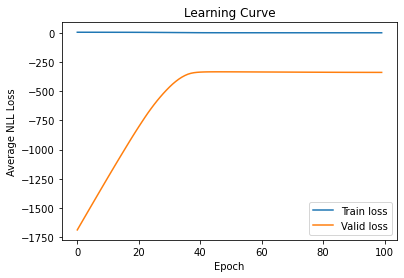

In [264]:
plt.plot(lgr.epoch_losses, label='Train loss')
plt.plot(lgr.vld_epoch_losses, label='Valid loss')
plt.title("Learning Curve")
plt.ylabel("Average NLL Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

Below we print out the training accuracy and confusion matrix. As we can see the training data is almost perfectly classified.

In [265]:
trn_acc = accuracy(y_hat=y_hat_trn, y=y_trn)
print(f"Training accuracy: {trn_acc}")

Accuracy ratio: 1705/1708
Training accuracy: 0.9982435597189696


Below we can see we only have 3 false negatives where 3 Bs (negative) were predicted when the actual labels were A (positive).

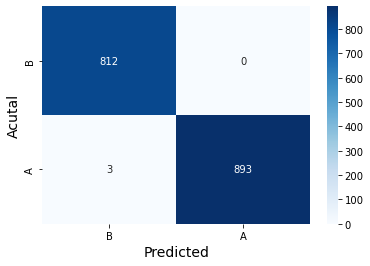

In [266]:
plot_confusion_matrix(
    y_hat=y_hat_trn, 
    y=y_trn,
    class_names=binary_class_names
);

Due to the 3 false negatives, we can see the TPR was negatively influenced as it measures the performance of all the actual positive samples.

In [267]:
compute_scores(
    y_hat=y_hat_trn, 
    y=y_trn, 
    class_names=binary_class_names
);

Scores for binary problem: positive label is A
	PPV ratio tp/(tp+fp): 893/893
	PPV (precision): 1.0

	TPR ratio tp/(tp+fn): 893/896
	TPR (recall/sensitivity): 0.9966517857142857

	TNR ratio tn/(tn+fp): 812/812
	TNR (specificity): 1.0


## Evaluating validation set

Now let's measure see how well the validation data did. We can expect these scores to be pretty good as the validation loss was even lower than the training loss in the learning curve plot.

In [268]:
y_hat_vld = lgr.predict(X_vld)

As expected, the scores are perfect!

In [269]:
vld_acc = accuracy(y_hat=y_hat_vld, y=y_vld)
print(f"Validation accuracy: {vld_acc}")

Accuracy ratio: 428/428
Validation accuracy: 1.0


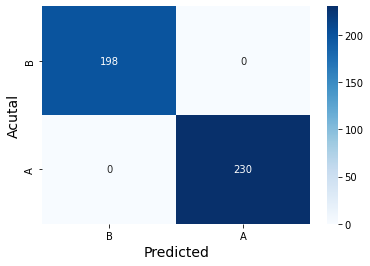

In [270]:
plot_confusion_matrix(
    y_hat=y_hat_vld, 
    y=y_vld,
    class_names=binary_class_names
);

In [271]:
compute_scores(
    y_hat=y_hat_vld, 
    y=y_vld, 
    class_names=binary_class_names
);

Scores for binary problem: positive label is A
	PPV ratio tp/(tp+fp): 230/230
	PPV (precision): 1.0

	TPR ratio tp/(tp+fn): 230/230
	TPR (recall/sensitivity): 1.0

	TNR ratio tn/(tn+fp): 198/198
	TNR (specificity): 1.0


## Evaluating test set

Now, given the performance of the training and validation data. We can assume that if our testing dataset is relatively similar to the training and validation dataset we should see good results. 

Remember, if any new unseen data is "too" different from training data used to learn the weights or the validation data used for assessing the training, our performance will degrade.

### Retraining
Let's retrain our model now by combining the training and validation data to form a new training dataset. Then, we can evaluate the performance using the unseen test dataset.

#### TODO 11
Complete the TODO by reinitializing `LogisticRegression` and rerunning training using the combined training and validation data before evaluating on the testing data.

1. Stack the training and validation data using the `np.vstack()` function. Store the output into `X_trn`.


2. Stack the training and validation labels using the `np.vstack()` function. Store the output into `y_trn`.


3. Create an instance of the `LogisticRegression`. Store the output into `lgr`. Pass the arguments that correspond to the following descriptions:
    1. 100 epochs
    1. learning rate of .05

In [272]:
# TODO 11.1
X_trn = np.vstack((X_trn, X_vld))
# TODO 11.2
y_trn = np.vstack((y_trn, y_vld))

# TODO 11.3
lgr = LogisticRegression(epochs = 100, alpha = .05)

lgr.fit(X_trn, y_trn)

y_hat_trn = lgr.predict(X_trn)

todo_check([
    (type(X_trn) is np.ndarray, "X_trn is not a NumPy array"),
    (y_trn.shape == (2136, 1), "y_trn does not have the shape (2136, 1)"),
    (y_tst.shape == (763, 1), "y_tst does not have the shape (763, 1)"),
    (np.all(np.unique(y_trn).flatten() == [0, 1]), "y_trn labels are not binary (0 or 1)"),
    (np.all(np.isclose(lgr.w[:3].flatten(),np.array([0.59729492, 0.39356357, 0.27028659]))), "lgr.w weight values are incorrect")
])


Epoch: 1/100
	Avg Training loss: 4.5235
Epoch: 2/100
	Avg Training loss: 4.5
Epoch: 3/100
	Avg Training loss: 4.4762
Epoch: 4/100
	Avg Training loss: 4.4547
Epoch: 5/100
	Avg Training loss: 4.4364
Epoch: 6/100
	Avg Training loss: 4.4201
Epoch: 7/100
	Avg Training loss: 4.4006
Epoch: 8/100
	Avg Training loss: 4.3758
Epoch: 9/100
	Avg Training loss: 4.3461
Epoch: 10/100
	Avg Training loss: 4.3112
Epoch: 11/100
	Avg Training loss: 4.2769
Epoch: 12/100
	Avg Training loss: 4.2432
Epoch: 13/100
	Avg Training loss: 4.2082
Epoch: 14/100
	Avg Training loss: 4.1708
Epoch: 15/100
	Avg Training loss: 4.1341
Epoch: 16/100
	Avg Training loss: 4.0989
Epoch: 17/100
	Avg Training loss: 4.0621
Epoch: 18/100
	Avg Training loss: 4.0125
Epoch: 19/100
	Avg Training loss: 3.9358
Epoch: 20/100
	Avg Training loss: 3.8493
Epoch: 21/100
	Avg Training loss: 3.766
Epoch: 22/100
	Avg Training loss: 3.6823
Epoch: 23/100
	Avg Training loss: 3.5959
Epoch: 24/100
	Avg Training loss: 3.469
Epoch: 25/100
	Avg Training lo

C:\Users\Anh T. Truong\AppData\Local\Temp\ipykernel_8904\839937138.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Notice, we only plot the training loss since the test dataset must remain untouched during the training process. By not assessing the testing dataset's loss during training, this prevents us from biasing the trained model. 

For instance, it is often popular to stop training when the validation loss begins to increase (this is called early stopping). If we did the same thing but using our testing data set it would further bias the model towards working just for the test dataset. Remember, we want to test dataset to be completely unseen and have no influence over our model!

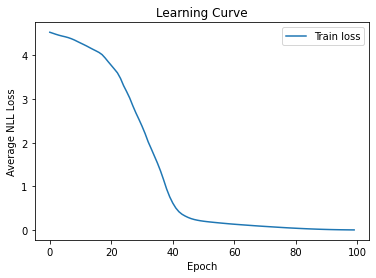

In [273]:
plt.plot(lgr.epoch_losses, label='Train loss')
plt.title("Learning Curve")
plt.ylabel("Average NLL Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

Once again, we can see the training data seems to be classified relatively well as we are still only getting 3 false negatives.

In [274]:
trn_acc = accuracy(y_hat=y_hat_trn, y=y_trn)
print(f"Training accuracy: {trn_acc}")

Accuracy ratio: 2133/2136
Training accuracy: 0.9985955056179775


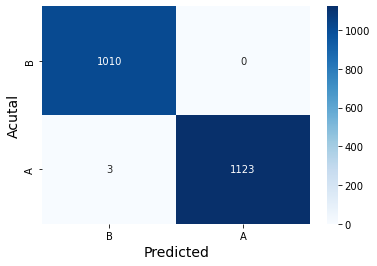

In [275]:
plot_confusion_matrix(
    y_hat=y_hat_trn, 
    y=y_trn,
    class_names=binary_class_names,
);

In [276]:
compute_scores(
    y_hat=y_hat_trn, 
    y=y_trn, 
    class_names=binary_class_names
);

Scores for binary problem: positive label is A
	PPV ratio tp/(tp+fp): 1123/1123
	PPV (precision): 1.0

	TPR ratio tp/(tp+fn): 1123/1126
	TPR (recall/sensitivity): 0.9973357015985791

	TNR ratio tn/(tn+fp): 1010/1010
	TNR (specificity): 1.0


### Evaluation

Now, let's see how the model does on the unseen testing data.

In [277]:
y_hat_tst = lgr.predict(X_tst)

As we can see, it predicts everything perfectly! This indicates we haven't overfit and our testing data is similar to the training and validation data.

In [278]:
tst_acc = accuracy(y_hat=y_hat_tst, y=y_tst)
print(f"Testing accuracy: {tst_acc}")

Accuracy ratio: 763/763
Testing accuracy: 1.0


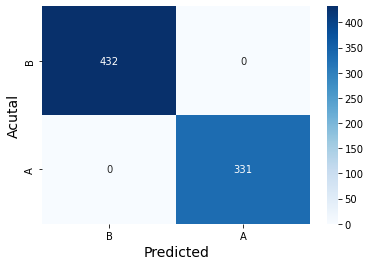

In [279]:
plot_confusion_matrix(
    y_hat=y_hat_tst, 
    y=y_tst,
    class_names=binary_class_names,
);

In [280]:
compute_scores(
    y_hat=y_hat_tst, 
    y=y_tst, 
    class_names=binary_class_names
);

Scores for binary problem: positive label is A
	PPV ratio tp/(tp+fp): 331/331
	PPV (precision): 1.0

	TPR ratio tp/(tp+fn): 331/331
	TPR (recall/sensitivity): 1.0

	TNR ratio tn/(tn+fp): 432/432
	TNR (specificity): 1.0


In [281]:
# Remove data variables for this section from memory
garbage_collect(['lgr', 'X_trn', 'y_trn', 'X_vld', 'y_vld','y_hat_trn', 'trn_acc', 'y_hat_vld', 'vld_acc', 'prob_of_misclassified', 'data', 'feature_names', 'trn_probs', 'trn_probs_df', 'vld_probs', 'vld_probs_df', 'y_hat_tst', 'tst_acc', 'binary_class_names'])

# Multi-class Logistic Regression

Next, let's tackle the much hard problem of 24 class classification. To do so, we'll need to use the more generalized version of logistic regression which uses the softmax activation function and is often referred to as softmax regression.

## Defining Logistic Regression with softmax
Recall that softmax regression outputs a probability for EACH class. Thus, if we have 3 classes the continuous output for a single data sample will be a vector of length 3. Further, the probability output will also be a vector of length 3 containing the probability the data sample belongs to each class. See the below image which visualizes this idea.

<img src="https://cdn-images-1.medium.com/max/906/1*670CdxchunD-yAuUWdI7Bw.png">

Before we can define the softmax regression class we need to, once again, define and review following two main aspects:

1. First, we'll need to define the activation function which will be the *softmax* activation function. 
2. Second, we'll need to generalize the NLL to work with more than two classes.


### Softmax
Recall, multi-class logistic regression with the softmax function is a generalization of binary logistic regression with the sigmoid function. Notice, the softmax formula is very similar to the sigmoid function. When performing binary classification with the softmax function acts exactly the same as if the sigmoid activation function was being used! 

The softmax activation function equation is given as follows:

$$
\begin{align}
P(y \mid \xv; \wv) = f(\xv; \wv) &= \frac{e^{\zv_i}}{\sum_{k=1}^K e^{\zv_k}}
\end{align}
$$

where in this equation
- $K$ the number of classes.
- $i$/$k$ refers to the $i$th/$k$th element in the vector $\zv$ (i.e., $i$th/$k$th class or column).
- $\zv$ is a continuous vector which contains the continuous predictions from the model. When using batch or mini-batches $\zv$ will be a matrix $\Zm$ with shape (number of features, number of classes).
- $e^{\zv_i}$ exponentiates each element in $\zv$. The exponential $e$ is used to prevent negative values. Further, values will be very small if the input is negative, and very large if the input is large. However, simply using $e$ means the value range is still not fixed between (0, 1) which is what is required of a probability.
- $\sum_{k=1}^K e^{\zv_k}$ is the normalizing term which ensures all values in $e^\zv$ sum to 1. Meaning, the range of all values will be between (0, 1) and sum to 1. To do so, the sum over all elements in $e^\zv$ is computed.



Further, recall that the softmax function can be numerically unstable. To fix this issue, we subtract the max of $\zv$ which can be seen as scaling down all the values within $\zv$. As we'll be using batch gradient descent, $\Zm$ will be a matrix so we want to subtract the max of each row.


#### TODO 12
Complete the TODO by implementing the `softmax()` function which returns the output of the softmax equation.

1. Subtract the max of each data sample over the columns from `z`. To get the max use the `np.max()` function. To ensure the output dimensions don't change, pass the `keepdims=True` argument. Store the output back into `z`.


2. Compute the exponential of `z` using the `np.exp()` function. Store the output into `e_z`.


3. Compute the denominator of the softmax equation by summing over `e_z`. Recall we want to reduce the COLUMNS such that we have a single value for each row (i.e., data sample). To ensure the output dimensions don't change, pass the `keepdims=True` argument. Store the output into `denominator`.


4. Compute the softmax output for every data sample by dividing `e_z` by the `denominator`. Store the output into `softmax`.

In [282]:
def softmax(z):
    # TODO 12.1
    z = z - np.max(z, axis = -1, keepdims = True)
    # TODO 12.2
    e_z = np.exp(z)
    # TODO 12.3
    denominator = np.sum(e_z, axis = -1, keepdims = True)
    # TODO 12.4
    softmax = e_z/denominator
    return softmax

Run the below code cells to test your implementation of the `softmax()` function. 

The below test is broken into two cases defined as follows:

1. First, it uses a single fake data sample defined as a vector with 3 fake classes. The fake data `rnd_z` contains the continuous values $\zv$ which are then turned into probabilities. 

2. Second, it uses multiple fake data samples defined as a matrix with 3 fake classes. The fake data `rnd_matrix_z` contains the continuous values $\Zm$ which are then turned into probabilities.

Remember, the columns correspond to classes and the rows correspond to data samples.

In [283]:
rng = np.random.RandomState(1)
rnd_z = rng.rand(1, 3)
rnd_z

array([[0.417022  , 0.72032449, 0.00011437]])

In [284]:
softmax_probs = softmax(rnd_z)
print(f"Softmax vector probabilities:\n{softmax_probs}")

todo_check([
    (np.all(np.isclose(softmax_probs, np.array([[0.33185042, 0.44943301, 0.21871657]]), rtol=.01)), "softmax_probs has incorrect values")
])

Softmax vector probabilities:
[[0.33185042 0.44943301 0.21871657]]
Your code PASSED the code check!


Notice the sum of the probabilities is 1, as we might expect!

In [285]:
np.sum(softmax_probs)

1.0

In [286]:
rng = np.random.RandomState(0)
rnd_matrix_z = rng.rand(5, 3)
rnd_matrix_z

array([[0.5488135 , 0.71518937, 0.60276338],
       [0.54488318, 0.4236548 , 0.64589411],
       [0.43758721, 0.891773  , 0.96366276],
       [0.38344152, 0.79172504, 0.52889492],
       [0.56804456, 0.92559664, 0.07103606]])

In [287]:
softmax_matrix_probs = softmax(rnd_matrix_z)
print(f"Softmax matrix probabilities:\n{softmax_matrix_probs}")

todo_check([
    (np.all(np.isclose(softmax_matrix_probs[:3, 0], np.array([0.30898065, 0.33421115, 0.23434743]), rtol=.01)), "softmax_matrix_probs has incorrecrt values"),
])

Softmax matrix probabilities:
[[0.30898065 0.36491138 0.32610797]
 [0.33421115 0.29605481 0.36973403]
 [0.23434743 0.36907156 0.396581  ]
 [0.27316453 0.41090326 0.31593222]
 [0.3291452  0.47062004 0.20023476]]
Your code PASSED the code check!


After applying the softmax notice the sum across each row (i.e., data sample) should be 1!

In [288]:
np.sum(softmax_matrix_probs, axis=1, keepdims=True)

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [289]:
garbage_collect(['rng', 'rnd_z', 'rnd_matrix_z', 'softmax_matrix_probs', 'softmax_probs'])

### Generalized Negative Log Loss 

Recall, by using the softmax we can generalize the NLL loss function for multiple classes. This generalization is also referred to as the *cross-entropy* loss function. The generalized NLL loss function is given as follows:

$$
NLL(\wv) = - \sum_{i=1}^{m} {\yv_i} * \log[f(\xv_i;\wv)]     
$$

The idea being that we compute the loss for each sample with respect to the observed true class label and the predicted probability for the observed true class label ONLY! We can achieve this by encoding the labels $y_i$ as a one-hot vector $\yv_i$ where only the column that corresponds to the ground truth label contains a 1 while the rest of the class columns contain a 0.

#### TODO 13
Before defining a function for generalized NLL let's break down the equation so we can see and understand how the loss function works. Complete the TODO by implementing parts of the generalized NLL equation and then implementing the `nll()` function.

1. Convert the generalized log likelihood equation given below into code. Notice, the negative sum is not included on purpose! Use `fake_yoh` in place of $y$ and `fake_probs` in place of $f(\xv_i;\wv)$. Store the output into `losses`.

$$
LL(\wv) = {\yv_i} * \log[f(\xv_i;\wv)] 
$$


2. Compute the average NLL loss for all data samples stored in `losses`. Remember to apply the negative after taking the mean. Store the output into `avg_loss`.
    1. Hint: Using `np.mean()` will not work as `losses` is a 2D array with many zero values. We want to only divide by the number of non-zero values. Thus, Use `np.sum()` and divide by number of data samples manually.
    
    
3. Using the prior TODOs as guidance, implement the `nll()` function by converting the NLL equation, given below, into code. Return the output of the mean of the NLL equation.


$$
NLL(\wv) = - \frac{1}{m}\sum_{i=1}^{m} {\yv_i} * \log[f(\xv_i;\wv)]     
$$

Below we define some fake one-hot labels `fake_yoh` and fake predicted probabilities `fake_probs`.  Further, remember each column corresponds to a class. Thus, `fake_yoh` gives the labels as a one-hot encoding and `fake_probs` gives the a probability that data sample belongs to the a class.


In [290]:
fake_yoh = np.array([
    [0., 1., 0.],
    [0., 0., 1.]
])
fake_yoh

array([[0., 1., 0.],
       [0., 0., 1.]])

In [291]:
fake_probs = np.array([
    [.1, .5, .4],
    [.1, .2, .7],
])
fake_probs

array([[0.1, 0.5, 0.4],
       [0.1, 0.2, 0.7]])

In [292]:
# TODO 13.1
losses = fake_yoh * np.log(fake_probs)
print(f"Log losses:\n{losses}")

todo_check([
    (np.all(np.isclose(losses.min(axis=1), [-0.69314718, -0.35667494],rtol=.01)), "losses has incorrect values")
])

Log losses:
[[-0.         -0.69314718 -0.        ]
 [-0.         -0.         -0.35667494]]
Your code PASSED the code check!


Notice, output will look similar to the binary NLL output, however now the loss is given as a 2D matrix. Further, the loss is computed only for the true class label!

For instance, the first data sample has a label of 1 so the loss is computed for only the probability of selecting class 1 is $\log(0.5)$. Additionally, the second data samples has a label of 2 so the loss is computed for only the probability of selecting class 2 is $\log(0.7)$. Notice the rest of the class losses go to zero because of the zeros in the one-hot encodings!

In [293]:
neg_losses = -losses
print(f"Negative log losses:\n{neg_losses}")

Negative log losses:
[[0.         0.69314718 0.        ]
 [0.         0.         0.35667494]]


In [294]:
# TODO 13.2
avg_loss = -np.sum(losses)/len(losses)
print(f"Average loss: {avg_loss}")

todo_check([
    (np.isclose(avg_loss, 0.524, rtol=.01), "avg_loss value is incorrect")
])

Average loss: 0.5249110622493389
Your code PASSED the code check!


In [295]:
# TODO 13.3
def nll(y, probs):
    losses = y * np.log(probs)
    return -np.sum(losses)/len(losses)

Run the below code to test your implementation of the `nll()` function.

In [296]:
avg_loss = nll(y=fake_yoh, probs=fake_probs)
print(f"Average loss: {avg_loss}")

todo_check([
    (np.isclose(avg_loss, 0.524, rtol=.01), "avg_loss value is incorrect")
])

Average loss: 0.5249110622493389
Your code PASSED the code check!


In [297]:
garbage_collect(['fake_y', 'fake_probs', 'losses', 'neg_losses', 'avg_loss'])

### Softmax Regression
As softmax regression uses weight updates and training loop we can simply inherit from `LogisticRegression`. In addition to inheriting, we can override the activation and loss function variables and the weight initialization and predict methods to make them specific to softmax regression implementation!

#### TODO 14
Complete this TODO by implementing the `SoftmaxRegression` class which inherits from the `LogisticRegression`class.



**TODOs for `__init__()` method**

1. Set the class variable `self.g` to store a **reference** to the `softmax` activation function. Recall, $g$ is the variable often used for activation function.


2. Set the class variable `self.loss_func` to store a **reference** to the `nll` loss function. 

**TODOs for `init_weights()` method**

3. Given the input features `X` and labels `y`, initialize the weights so that they have the shape (features, classes). Store the output into `self.w`.
    1. Hint: The rows of the weights `self.w` correspond to features and columns corresponds to classes.

**TODOs for `predict()` method**

4. Make the continuous predictions using the data `X` and weights `self.w`. Store the output into `z`.


5. Pass the continuous output `z` to the softmax function stored in `self.g` to get the predicted probabilities for each class. Store the output into `probs`.


6. Select the predicted labels by taking the argmax using `np.argmax()` over the columns (i.e., classes). Store the output into `y_hat`. 

In [298]:
class SoftmaxRegression(LogisticRegression):
    def __init__(self, epochs=1, alpha=.01):
        super().__init__(epochs, alpha)
        # TODO 14.1
        self.g = softmax
        # TODO 14.2
        self.loss_func = nll 
        
    def init_weights(self, X, y, seed):
        rng = np.random.RandomState(seed)
        # TODO 14.3
        self.w = rng.rand(X.shape[1], y.shape[1])
        
    def predict(self, X):
        # TODO 14.4
        z = X @ self.w
        # TODO 14.5
        probs = self.g(z)
        # TODO 14.6
        y_hat = np.argmax(probs, axis = 1)
        
        return y_hat.reshape(-1,1)

Run the `TEST_SoftmaxRegression()` function to test your implementation of the `SoftmaxRegression` class.

Epoch: 1/100
	Avg Training loss: 1.3112
	Avg Validation loss: 3.0523
Epoch: 2/100
	Avg Training loss: 1.1718
	Avg Validation loss: 3.0314
Epoch: 3/100
	Avg Training loss: 1.0557
	Avg Validation loss: 2.9898
Epoch: 4/100
	Avg Training loss: 0.9595
	Avg Validation loss: 2.9389
Epoch: 5/100
	Avg Training loss: 0.8797
	Avg Validation loss: 2.8843
Epoch: 6/100
	Avg Training loss: 0.8134
	Avg Validation loss: 2.8277
Epoch: 7/100
	Avg Training loss: 0.7578
	Avg Validation loss: 2.7696
Epoch: 8/100
	Avg Training loss: 0.7106
	Avg Validation loss: 2.7093
Epoch: 9/100
	Avg Training loss: 0.6702
	Avg Validation loss: 2.6464
Epoch: 10/100
	Avg Training loss: 0.6351
	Avg Validation loss: 2.5806
Epoch: 11/100
	Avg Training loss: 0.6043
	Avg Validation loss: 2.5117
Epoch: 12/100
	Avg Training loss: 0.5771
	Avg Validation loss: 2.4397
Epoch: 13/100
	Avg Training loss: 0.5528
	Avg Validation loss: 2.3646
Epoch: 14/100
	Avg Training loss: 0.5309
	Avg Validation loss: 2.2868
Epoch: 15/100
	Avg Training l

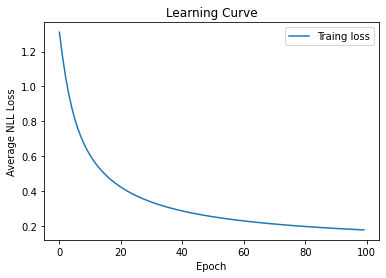

Accuracy ratio: 197/200
Accuracy: 0.985
Weights: [ 0.32522756  0.81611172  0.72542696  1.28720258 -0.93525136  1.26248087
  1.93565133  0.45895332 -0.10158168]
Your code PASSED the code check!


In [299]:
from sklearn.datasets import make_blobs

def TEST_SoftmaxRegression():
    
    def multi_class_data(
        n_samples: int = 1000, 
        balance: List = None,
        seed: int = 42
    ) -> List[np.ndarray]:

        def onehot(y):
            n_values = np.max(y) + 1
            oh = np.eye(n_values)[y.flatten()]
            return oh

        X, y = make_blobs(n_samples=1000,
                          random_state=seed,  
                          centers=[[2, 1.5], [-1.5, -1], [1, -1]],
                          cluster_std=0.6)
        y = onehot(y.reshape(-1, 1))
        # Add bias
        X = np.hstack([np.ones([len(X), 1]), X])

        return X, y

    X, y = multi_class_data()
    X_trn, y_trn, X_vld, y_vld = train_valid_split(X, y)

    smr = SoftmaxRegression(epochs=100, alpha=.1)
    smr.fit(X_trn, y_trn, X_vld=X_vld, y_vld=y_vld)
    y_hat = smr.predict(X_vld)

    plt.plot(smr.epoch_losses, label='Traing loss')
    plt.title("Learning Curve")
    plt.ylabel("Average NLL Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

    acc = accuracy(y_vld, y_hat)
    print(f"Accuracy: {acc}")
    print(f"Weights: {smr.w.flatten()}")

    todo_check([
        (acc == .985, "Incorrect accuracy value"),
        (np.all(np.isclose(smr.w.flatten()[:3], np.array([ 0.32522756,  0.81611172,  0.72542696]), rtol=.01)), "Incorrect weight values")
    ])
       
TEST_SoftmaxRegression()
garbage_collect(['TEST_SoftmaxRegression'])

## Training

Now, let's test softmax regression using ALL our multi-class classification data. 

#### TODO 15
Complete the TODO by getting the data, training the `SoftmaxRegression` class, making predictions, and visualizing/analyzing the results.

<font color='red'>**Warning: this may take 20-60+ seconds to run!**</font>

1. Call the `data_prep()` so that it will return multi-class classification data as NumPy arrays by passing the arguments which correspond to the following:
    1. Pass all required arguments for `trn_df`, `tst_df`, and `label_name`.
    1. Apply the target `target_pipeline()` to labels/targets so that they are one-hot encoded.
    1. Return all data as NumPy arrays.
    
    
2. Create an instance of the `SoftmaxRegression`. Store the output into `smr`. Pass the arguments that correspond to the following descriptions:
    1. 100 epochs
    1. learning rate of .3


3. Call the `fit()` method and pass the training data to the **arguments** `X` and `y`  and the validation data to the **arguments** `X_vld` and `y_vld`.

In [300]:
# TODO 15.1
data = data_prep(asl_trn_df, asl_tst_df, label_name = 'label', use_target_pipeline = True, return_array = True)
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = data


# TODO 15.2
smr = SoftmaxRegression(epochs = 100, alpha = .3)

# TODO 15.3
smr.fit(X = X_trn, y = y_trn, X_vld = X_vld, y_vld = y_vld)

y_hat_trn = smr.predict(X_trn)

todo_check([
    (y_trn.shape == (21964, 24), "y_trn does not have the shape 21964, 24)"),
    (y_vld.shape == (5491, 24), "y_vld does not have the shape (5491, 24)"),
    (y_tst.shape == (7172, 24), "y_tst does not have the shape (7172, 24)"),
    (np.all(np.isclose(smr.w[3, :3], np.array([0.99169267, 0.61082331, 0.73585151]), rtol=.01)), "smr.w has incorrect weight values")
])


Epoch: 1/100
	Avg Training loss: 13.182
	Avg Validation loss: -5125.1052
Epoch: 2/100
	Avg Training loss: 9.3289
	Avg Validation loss: -4535.0757
Epoch: 3/100
	Avg Training loss: 7.8858
	Avg Validation loss: -4851.005
Epoch: 4/100
	Avg Training loss: 6.9304
	Avg Validation loss: -4429.0866
Epoch: 5/100
	Avg Training loss: 6.202
	Avg Validation loss: -4751.7098
Epoch: 6/100
	Avg Training loss: 5.6162
	Avg Validation loss: -4238.089
Epoch: 7/100
	Avg Training loss: 5.1504
	Avg Validation loss: -4662.045
Epoch: 8/100
	Avg Training loss: 4.7672
	Avg Validation loss: -4331.978
Epoch: 9/100
	Avg Training loss: 4.4958
	Avg Validation loss: -4572.1878
Epoch: 10/100
	Avg Training loss: 4.2394
	Avg Validation loss: -4856.8379
Epoch: 11/100
	Avg Training loss: 4.0753
	Avg Validation loss: -4158.4438
Epoch: 12/100
	Avg Training loss: 3.9265
	Avg Validation loss: -5754.8954
Epoch: 13/100
	Avg Training loss: 3.7846
	Avg Validation loss: -3662.0331
Epoch: 14/100
	Avg Training loss: 3.7372
	Avg Valida

Once again, we can observe the learning curve below. It seems training went well as the training and validation losses are very close. Additionally, both losses decline over time and then flatten out indicating learning has slowed down.

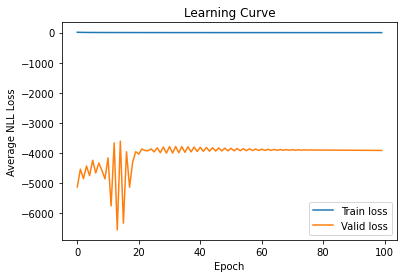

In [301]:
plt.plot(smr.epoch_losses, label='Train loss')
plt.plot(smr.vld_epoch_losses, label='Valid loss')
plt.title("Learning Curve")
plt.ylabel("Average NLL Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

Before we look at the confusion matrix and other scores, we need to make a note of how to get the original class labels back. Notice, that when we make a prediction we get the following:

In [302]:
y_hat_trn

array([[ 9],
       [14],
       [ 0],
       ...,
       [ 4],
       [ 7],
       [14]], dtype=int64)

You might think these predicted labels correspond to the actual class labels but they don't! Instead, these predictions correspond to the index of the class labels. Thus, to get the original class labels we need to index `class_labels` by `y_hat_trn`. 

Our predict method predicts the class label indexes becuase our class labels dont correspond 1-1 with the indexes of the array they are stored in. This is because the letters J and Z are excluded. For example, label 10 occurs at index 9!

In [303]:
class_labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24], dtype=int64)

In [304]:
class_labels[9]

10

The same issue arises when we want to get the original ground truth class labels back from the one-hot encoding. Notice, when we take the argmax of `y_trn` we get the class label indexes again!

In [305]:
np.argmax(y_trn, axis=1)

array([ 9, 14,  0, ..., 13,  7, 14], dtype=int64)

In [306]:
class_labels[np.argmax(y_trn, axis=1)]

array([10, 15,  0, ..., 14,  7, 15], dtype=int64)

Knowing this, we can still compute all the metrics using the predicted class label indexes. However, if we want to label the confusion matrix correctly we need to get the original class labels back!

In [307]:
trn_acc = accuracy(y_hat=y_hat_trn, y=y_trn)
print(f"Training accuracy: {trn_acc}")

Accuracy ratio: 18073/21964
Training accuracy: 0.822846476051721


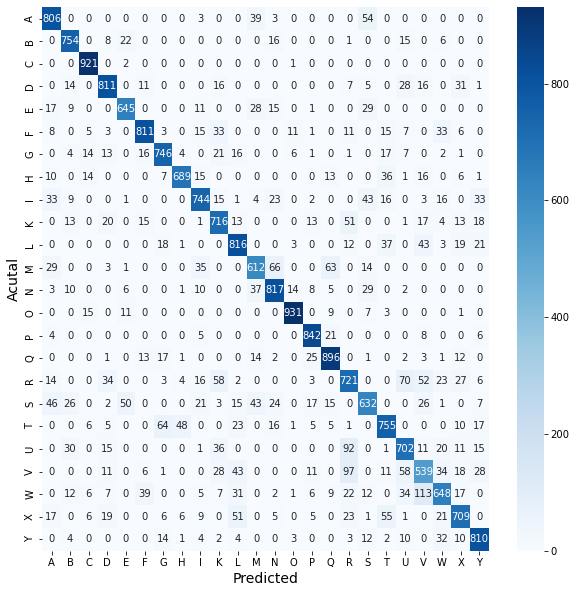

In [308]:
plot_confusion_matrix(
    y_hat=class_labels[y_hat_trn], 
    y=class_labels[np.argmax(y_trn, axis=1)],
    class_names=class_names,
    figsize=(10,10)
);

Notice that training only achieved ~80% accuracy. If we gave the training more epochs it might achieve a higher score. However, since the learning curve is beginning to flatten things might not get all that better.

## Evaluating validation set

Now let's measure see how well the validation data did. We can expect these scores to be comparable to the training scores as the losses were relatively similar.

In [309]:
y_hat_vld = smr.predict(X_vld)

As we can see, the accuracy is quite similar as expected.

In [310]:
vld_acc = accuracy(y_hat=y_hat_vld, y=y_vld)
print(f"Validation accuracy: {vld_acc}")

Accuracy ratio: 4405/5491
Validation accuracy: 0.8022218175195774


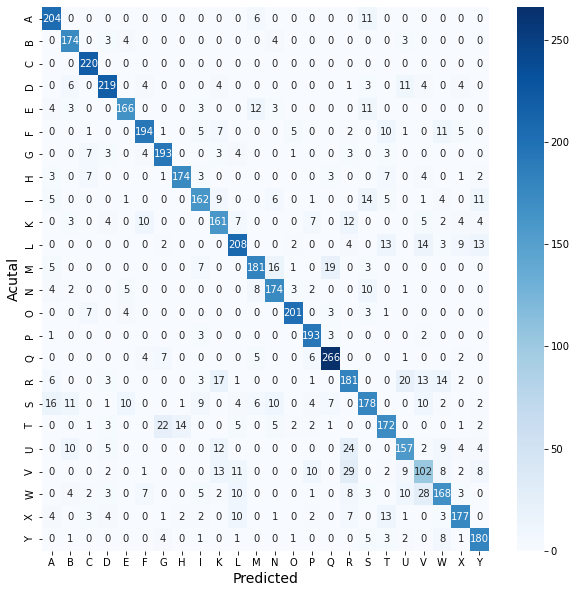

In [311]:
plot_confusion_matrix(
    y_hat=class_labels[y_hat_vld], 
    y=class_labels[np.argmax(y_vld, axis=1)],
    class_names=class_names,
    figsize=(10,10)
);

## Evaluating test set

Now, given the performance of the training and validation data. We can assume that if our testing dataset is relatively similar to the training and validation dataset we should see good results. 

Remember, if any new unseen data is "too" different from training data used to learn the weights or the validation data used for assessing the training, our performance will degrade.

### Retraining
Let's retrain our model now by combining the training and validation data to form a new training dataset. Then, we can evaluate the performance using the unseen test dataset.


#### TODO 16

Complete the TODO by reinitializing `SoftmaxRegression` and rerunning training using the combined training and validation data before evaluating on the testing data.

<font color='red'>**Warning: this may take 20-60+ seconds to run!**</font>

1. Stack the training and validation data using the `np.vstack()` function. Store the output into `X_trn`.

2. Stack the training and validation labels using the `np.vstack()` function. Store the output into `y_trn`.

3. Create an instance of the `SoftmaxRegression`. Store the output into `smr`. Pass the arguments that correspond to the following descriptions:
    1. 100 epochs
    1. learning rate of .3

In [312]:
# TODO 16.1
X_trn = np.vstack((X_trn, X_vld))
# TODO 16.2
y_trn = np.vstack((y_trn, y_vld))

# TODO 16.3
smr = SoftmaxRegression(epochs = 100, alpha = .3)

smr.fit(X_trn, y_trn)

y_hat_trn = smr.predict(X_trn)

todo_check([
    (y_trn.shape == (27455, 24), "y_trn does not have the shape 27455, 24)"),
    (np.all(np.isclose(smr.w[3, :3], np.array([0.9909965 , 0.61222723, 0.73552686]), rtol=.001)), "smr.w weight values are incorrect")
])


Epoch: 1/100
	Avg Training loss: 13.1891
Epoch: 2/100
	Avg Training loss: 9.321
Epoch: 3/100
	Avg Training loss: 7.8973
Epoch: 4/100
	Avg Training loss: 6.9491
Epoch: 5/100
	Avg Training loss: 6.2234
Epoch: 6/100
	Avg Training loss: 5.6408
Epoch: 7/100
	Avg Training loss: 5.1736
Epoch: 8/100
	Avg Training loss: 4.7866
Epoch: 9/100
	Avg Training loss: 4.5074
Epoch: 10/100
	Avg Training loss: 4.2458
Epoch: 11/100
	Avg Training loss: 4.0776
Epoch: 12/100
	Avg Training loss: 3.9206
Epoch: 13/100
	Avg Training loss: 3.7791
Epoch: 14/100
	Avg Training loss: 3.7351
Epoch: 15/100
	Avg Training loss: 3.5616
Epoch: 16/100
	Avg Training loss: 3.5427
Epoch: 17/100
	Avg Training loss: 3.3111
Epoch: 18/100
	Avg Training loss: 3.2666
Epoch: 19/100
	Avg Training loss: 2.9897
Epoch: 20/100
	Avg Training loss: 2.9137
Epoch: 21/100
	Avg Training loss: 2.6707
Epoch: 22/100
	Avg Training loss: 2.5802
Epoch: 23/100
	Avg Training loss: 2.4713
Epoch: 24/100
	Avg Training loss: 2.3916
Epoch: 25/100
	Avg Traini

As we can see, with the new combined training dataset the learning curve, accuracy, and other metrics remain relatively the same. 

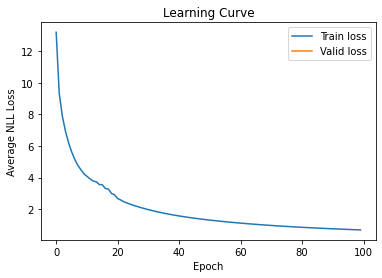

In [313]:
plt.plot(smr.epoch_losses, label='Train loss')
plt.plot(smr.vld_epoch_losses, label='Valid loss')
plt.title("Learning Curve")
plt.ylabel("Average NLL Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [314]:
trn_acc = accuracy(y_hat=y_hat_trn, y=y_trn)
print(f"Training accuracy: {trn_acc}")

Accuracy ratio: 22447/27455
Training accuracy: 0.8175924239664906


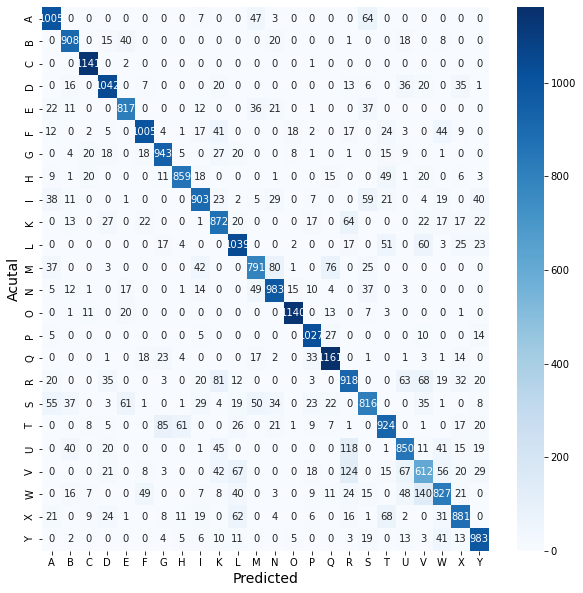

In [315]:
plot_confusion_matrix(
    y_hat=class_labels[y_hat_trn], 
    y=class_labels[np.argmax(y_trn, axis=1)],
    class_names=class_names,
    figsize=(10,10)
);

### Evaluation
Now, let's see how the model does on the unseen testing data.

In [316]:
y_hat_tst = smr.predict(X_tst)

Wait a second, our model is performing horribly! What is going on here? The training and validation scores were so good, how could this have happened?

In [317]:
tst_acc = accuracy(y_hat=y_hat_tst, y=y_tst)
print(f"Testing accuracy: {tst_acc}")

Accuracy ratio: 3807/7172
Testing accuracy: 0.5308142777467931


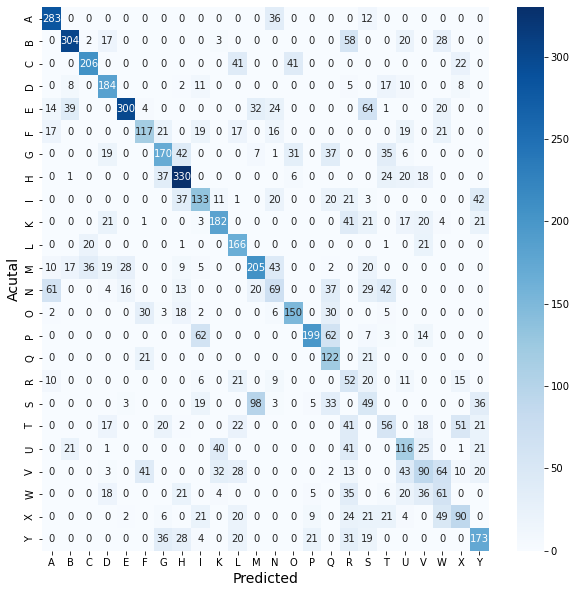

In [318]:
plot_confusion_matrix(
    y_hat=class_labels[y_hat_tst], 
    y=class_labels[np.argmax(y_tst, axis=1)],
    class_names=class_names,
    figsize=(10,10)
);

### Exploring the issue

Let's take a closer look at what is happening here by passing the testing dataset to the `fit()` method and observing it's learning curve. Now, this is typically not recommended as when we do this we can bias the selection of the training model. However, to understand what is happening, often this can be required. In practice, if you ever do this you'll need to find another test set!

#### TODO 17
Complete the TODO by reinitializing `SoftmaxRegression` and rerunning training using the test set as the validation set so that we can observe the learning curve for the test dataset.  

<font color='red'>**Warning: this may take 20-60+ seconds to run!**</font>



1. Create an new instance of the `SoftmaxRegression`. Store the output into `smr`. Pass the arguments that correspond to the following descriptions:
    1. 100 epochs
    1. learning rate of .3


2. Call the `fit()` method and pass the  <u>training data</u>  to the **arguments** `X` and `y`  and the <u>testing data</u> to the **arguments** `X_vld` and `y_vld`.


In [320]:
# TODO 17.1
smr = SoftmaxRegression(epochs = 100, alpha = .3)

# TODO 17.2
smr.fit(X_trn, y_trn, X_vld = X_tst, y_vld = y_tst)

y_hat_trn = smr.predict(X_trn)

todo_check([
    (np.isclose(smr.vld_epoch_losses[0], 9.814348711, rtol=.001), "smr.vld_epoch_losses values incorrect")
])


Epoch: 1/100
	Avg Training loss: 13.1891
	Avg Validation loss: 833.2806
Epoch: 2/100
	Avg Training loss: 9.321
	Avg Validation loss: 984.4651
Epoch: 3/100
	Avg Training loss: 7.8973
	Avg Validation loss: 633.8598
Epoch: 4/100
	Avg Training loss: 6.9491
	Avg Validation loss: 739.3486
Epoch: 5/100
	Avg Training loss: 6.2234
	Avg Validation loss: 672.0159
Epoch: 6/100
	Avg Training loss: 5.6408
	Avg Validation loss: 943.4772
Epoch: 7/100
	Avg Training loss: 5.1736
	Avg Validation loss: 874.7302
Epoch: 8/100
	Avg Training loss: 4.7866
	Avg Validation loss: 1071.2531
Epoch: 9/100
	Avg Training loss: 4.5074
	Avg Validation loss: 1076.2623
Epoch: 10/100
	Avg Training loss: 4.2458
	Avg Validation loss: 940.3289
Epoch: 11/100
	Avg Training loss: 4.0776
	Avg Validation loss: 1602.4237
Epoch: 12/100
	Avg Training loss: 3.9206
	Avg Validation loss: 510.5027
Epoch: 13/100
	Avg Training loss: 3.7791
	Avg Validation loss: 2459.3432
Epoch: 14/100
	Avg Training loss: 3.7351
	Avg Validation loss: -4.440

AssertionError: You passed 0/1 and FAILED the following code checks:
Failed check [1]:
	 Tip: smr.vld_epoch_losses values incorrect

Let's look at the learning curve now which is given below.

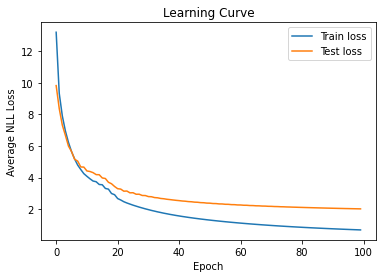

In [ ]:
plt.plot(smr.epoch_losses, label='Train loss')
plt.plot(smr.vld_epoch_losses, label='Test loss')
plt.title("Learning Curve")
plt.ylabel("Average NLL Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

Ah, interesting! Notice that for a time the test loss decreases with the training loss. However, the test loss begins to flatten out way sooner than the training loss. 

What does this mean? Well, this indicates that our testing dataset is relatively different from the training dataset. We can confirm this by looking at the "Avg validation loss" output, which is output while running the training. Notice, the testing loss values from epoch to epoch never really increase, rather the rate of decrease simply slows way down.

To help alleviate this issue, we would need to diversify the training dataset to account for the variations in testing data that are not including in the training data.

If you want to learn more checkout this [post](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/) on interpreting learning curves. Finally note, if the testing loss began to increase instead of flatten out, we could also consider that the model is overfitting as well.

In [ ]:
# Remove data variables for this section from memory
garbage_collect(['smr', 'X_trn', 'y_trn', 'X_vld', 'y_vld','y_hat_trn', 'trn_acc', 'y_hat_vld', 'vld_acc', 'prob_of_misclassified', 'data', 'feature_names', 'trn_probs', 'trn_probs_df', 'vld_probs', 'vld_probs_df', 'y_hat_tst', 'tst_acc'])